# Analisis Prototipo 2: Simulador de Trafico Aereo
Notebook limpio y ordenado para el analisis del Prototipo 2.


## 1. Importacion de librerias y configuracion global


In [296]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11
sns.set_palette("tab10")

FIG_DIR = "figuras_prototipo2"
os.makedirs(FIG_DIR, exist_ok=True)


## 2. Carga de datos


In [297]:
# Carga de datos
BASE_DIR = os.path.join('..', 'prototipos', 'prototipo2')
RESULTADOS_DIR = os.path.join(BASE_DIR, 'salidas', 'resultados')
EVENTOS_DIR = os.path.join(BASE_DIR, 'salidas', 'eventos')
PLANES_DIR = os.path.join(BASE_DIR, 'salidas', 'planes')
FUENTES_DIR = os.path.join(BASE_DIR, 'fuentes_de_datos')

r_vuelos = os.path.join(RESULTADOS_DIR, 'resultados_p2.csv')
r_aerop = os.path.join(RESULTADOS_DIR, 'resultados_por_aeropuerto_p2.csv')
r_eventos = os.path.join(EVENTOS_DIR, 'eventos_p2.csv')
r_logs = os.path.join(EVENTOS_DIR, 'logs_vuelos_p2.csv')
r_plan = os.path.join(PLANES_DIR, 'plan_usado_p2.csv')
r_flujo = os.path.join(FUENTES_DIR, 'Flujo_Aeropuertos_Espanoles.csv')
r_aerop_enr = os.path.join(FUENTES_DIR, 'aeropuertos_enriquecidos.csv')

df_vuelos = pd.read_csv(r_vuelos)
df_aerop = pd.read_csv(r_aerop)
df_eventos = pd.read_csv(r_eventos)
df_logs = pd.read_csv(r_logs)
try:
    df_plan = pd.read_csv(r_plan)
except FileNotFoundError:
    df_plan = None
try:
    df_aerop_enr = pd.read_csv(r_aerop_enr)
except FileNotFoundError:
    df_aerop_enr = pd.DataFrame()

for df in [df_vuelos, df_aerop, df_eventos, df_logs, df_aerop_enr]:
    if 'dia' in df.columns:
        df['dia'] = df['dia'].astype(int)

if 'redirigido' in df_vuelos.columns:
    df_vuelos['redirigido'] = df_vuelos['redirigido'].astype(bool)

col_delay = 'retraso_total_min'
redir_series = df_vuelos['redirigido'] if 'redirigido' in df_vuelos.columns else pd.Series(False, index=df_vuelos.index)
df_vuelos['categoria_retraso'] = np.select(
    [redir_series,
     df_vuelos[col_delay] <= 0,
     (df_vuelos[col_delay] > 0) & (df_vuelos[col_delay] <= 15),
     (df_vuelos[col_delay] > 15) & (df_vuelos[col_delay] <= 30),
     df_vuelos[col_delay] > 30],
    ['redirigido','sin_retraso','retraso_poco','retraso_comun','retraso_grave'],
    default='sin_dato'
)


## 3. Rendimiento global


In [298]:
col_delay = 'retraso_total_min'
cat_counts = df_vuelos['categoria_retraso'].value_counts()
total_vuelos = len(df_vuelos)
porc_cat = (cat_counts/total_vuelos*100).to_dict()
retrasos_pos = df_vuelos.loc[df_vuelos[col_delay]>0, col_delay]
print(f"Total de vuelos: {total_vuelos}")
for nombre in ['sin_retraso','retraso_leve','retraso_comun','retraso_grave','redirigido']:
    print(f"{nombre}: {cat_counts.get(nombre,0)} ({porc_cat.get(nombre,0):.1f}%)")
print(f"Retraso medio +: {retrasos_pos.mean():.1f} min")
print(f"P90: {retrasos_pos.quantile(0.9):.1f} min | P95: {retrasos_pos.quantile(0.95):.1f} min")


Total de vuelos: 21000
sin_retraso: 846 (4.0%)
retraso_leve: 0 (0.0%)
retraso_comun: 11391 (54.2%)
retraso_grave: 4432 (21.1%)
redirigido: 1 (0.0%)
Retraso medio +: 22.9 min
P90: 38.1 min | P95: 49.7 min


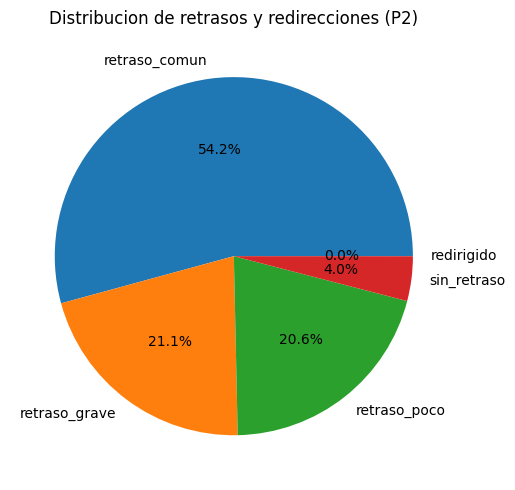

In [299]:
# Pie categorias
cat_counts = df_vuelos['categoria_retraso'].value_counts()
fig, ax = plt.subplots()
cat_counts.plot(kind='pie', autopct='%1.1f%%', ax=ax)
ax.set_ylabel('')
ax.set_title('Distribucion de retrasos y redirecciones (P2)')
plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'pie_retrasos_global_p2.png'))


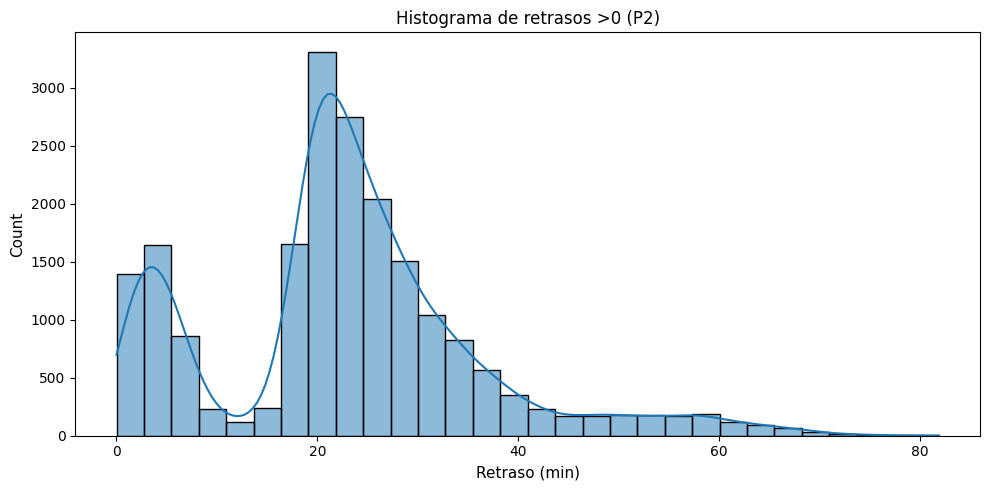

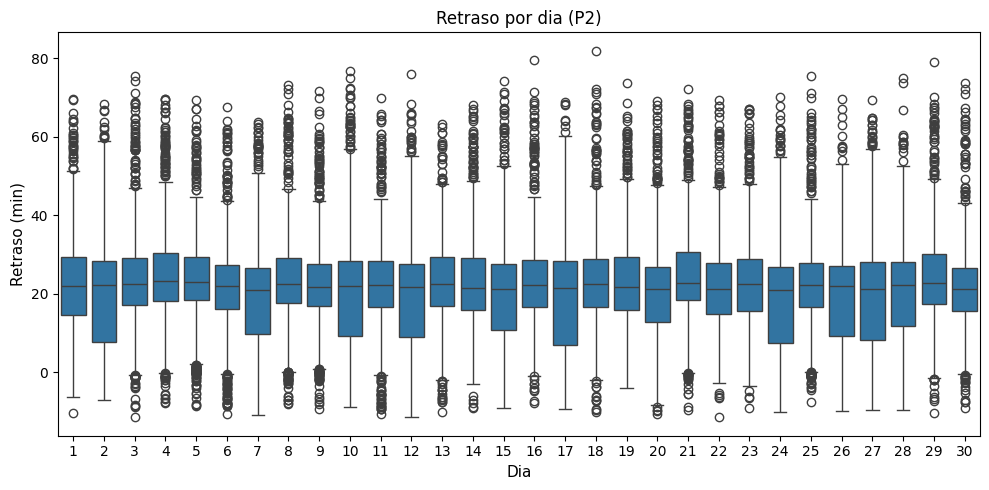

In [300]:
# Histograma y box por dia
retrasos_pos = df_vuelos.loc[df_vuelos[col_delay]>0, col_delay]
fig, ax = plt.subplots(); sns.histplot(retrasos_pos, bins=30, kde=True, ax=ax); ax.set_xlabel('Retraso (min)'); ax.set_title('Histograma de retrasos >0 (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'hist_retrasos_p2.png'))
fig, ax = plt.subplots(); sns.boxplot(data=df_vuelos, x='dia', y=col_delay, ax=ax); ax.set_xlabel('Dia'); ax.set_ylabel('Retraso (min)'); ax.set_title('Retraso por dia (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'box_retraso_medio_por_dia_p2.png'))


## 4. Redirecciones y congestion


In [301]:
col_delay = 'retraso_total_min'
redir_totales = df_vuelos['redirigido'].sum() if 'redirigido' in df_vuelos.columns else np.nan
print('Vuelos redirigidos:', redir_totales)
if 'retraso_por_redireccion_min' in df_vuelos.columns:
    retraso_extra = df_vuelos.loc[df_vuelos['redirigido'], 'retraso_por_redireccion_min'].mean()
    print(f'Retraso extra medio por redireccion: {retraso_extra:.1f} min')
else:
    print('No hay columna de retraso_extra')

if {'vuelos_redirigidos_salientes','vuelos_redirigidos_recibidos'}.issubset(df_aerop.columns):
    aerop_redir = df_aerop.groupby('aeropuerto')[['vuelos_redirigidos_salientes','vuelos_redirigidos_recibidos']].sum()
else:
    aerop_redir = pd.DataFrame()

if 'retraso_medio_llegadas_min' in df_aerop.columns:
    aerop_delay = df_aerop.groupby('aeropuerto')['retraso_medio_llegadas_min'].mean()
else:
    aerop_delay = pd.Series(dtype=float)


Vuelos redirigidos: 1
Retraso extra medio por redireccion: 9.2 min


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


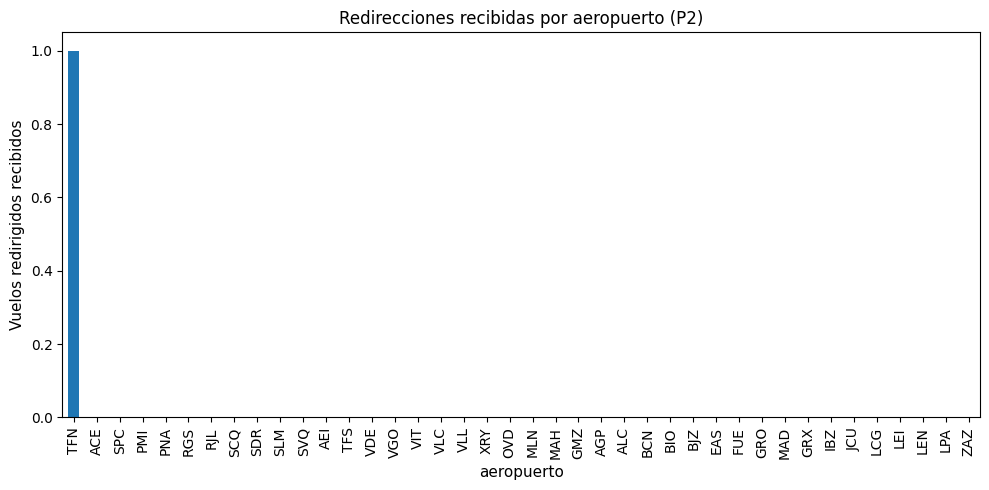

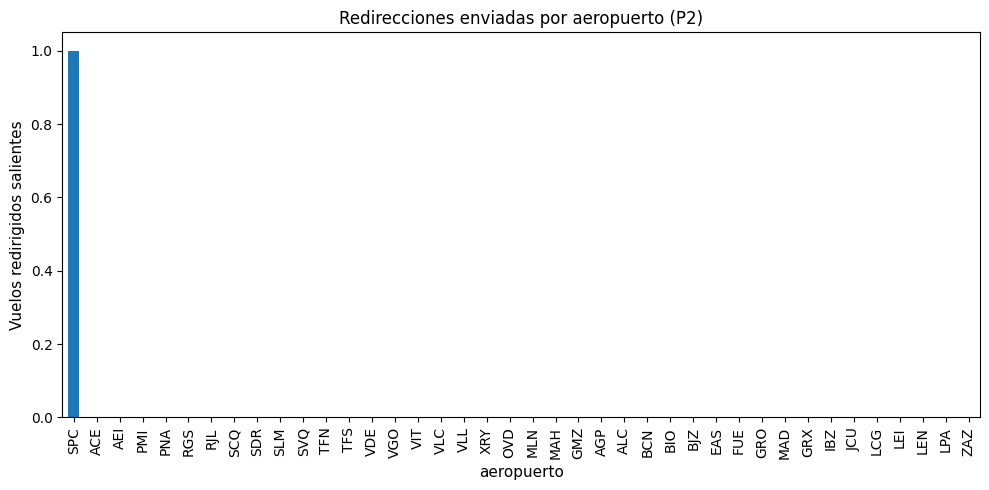

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


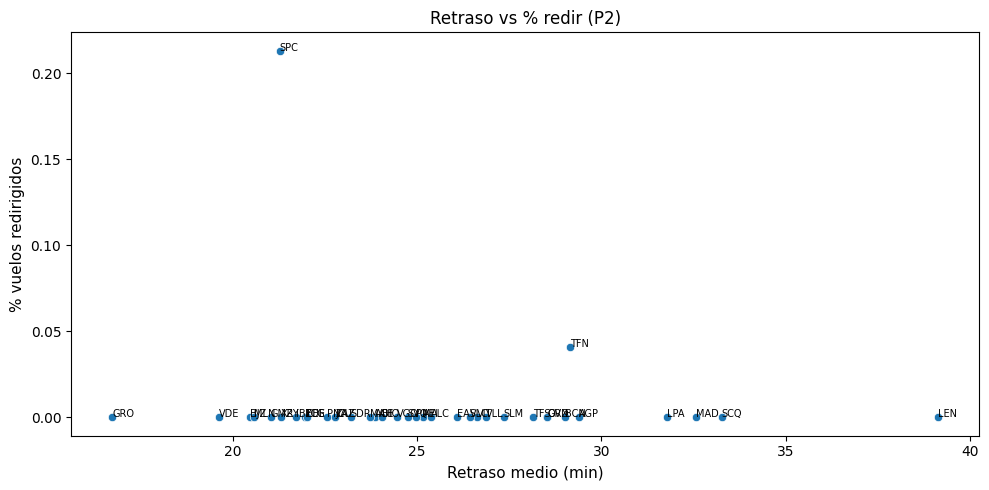

In [302]:
if not aerop_redir.empty:
    fig, ax = plt.subplots(); aerop_redir['vuelos_redirigidos_recibidos'].sort_values(ascending=False).plot(kind='bar', ax=ax)
    ax.set_title('Redirecciones recibidas por aeropuerto (P2)'); ax.set_ylabel('Vuelos redirigidos recibidos'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'redirigidos_recibidos_por_aeropuerto_p2.png'))
    fig, ax = plt.subplots(); aerop_redir['vuelos_redirigidos_salientes'].sort_values(ascending=False).plot(kind='bar', ax=ax)
    ax.set_title('Redirecciones enviadas por aeropuerto (P2)'); ax.set_ylabel('Vuelos redirigidos salientes'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'redirigidos_salientes_por_aeropuerto_p2.png'))

if not aerop_redir.empty and not aerop_delay.empty and {'vuelos_llegadas','vuelos_salidas'}.issubset(df_aerop.columns):
    aerop_tot_vuelos = df_aerop.groupby('aeropuerto')[['vuelos_llegadas','vuelos_salidas']].sum().sum(axis=1)
    aerop_redir_pct = (aerop_redir['vuelos_redirigidos_recibidos'] + aerop_redir['vuelos_redirigidos_salientes'])/aerop_tot_vuelos*100
    scatter_df = pd.DataFrame({'retraso_medio': aerop_delay, 'pct_redir': aerop_redir_pct})
    fig, ax = plt.subplots(); sns.scatterplot(data=scatter_df, x='retraso_medio', y='pct_redir', ax=ax)
    for a,row in scatter_df.iterrows(): ax.text(row['retraso_medio'], row['pct_redir'], a, fontsize=7)
    ax.set_xlabel('Retraso medio (min)'); ax.set_ylabel('% vuelos redirigidos'); ax.set_title('Retraso vs % redir (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'scatter_retraso_vs_porcentaje_redir_p2.png'))


## 5. Analisis espacial por aeropuerto


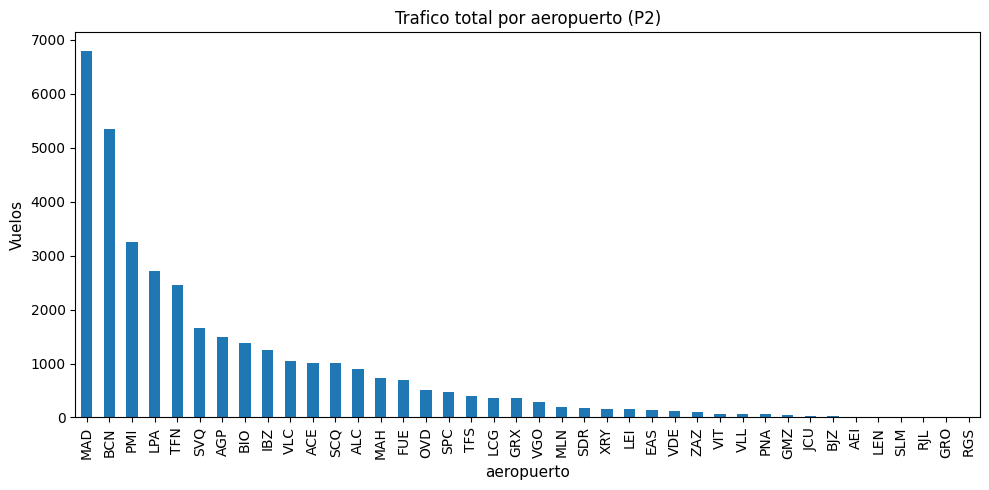

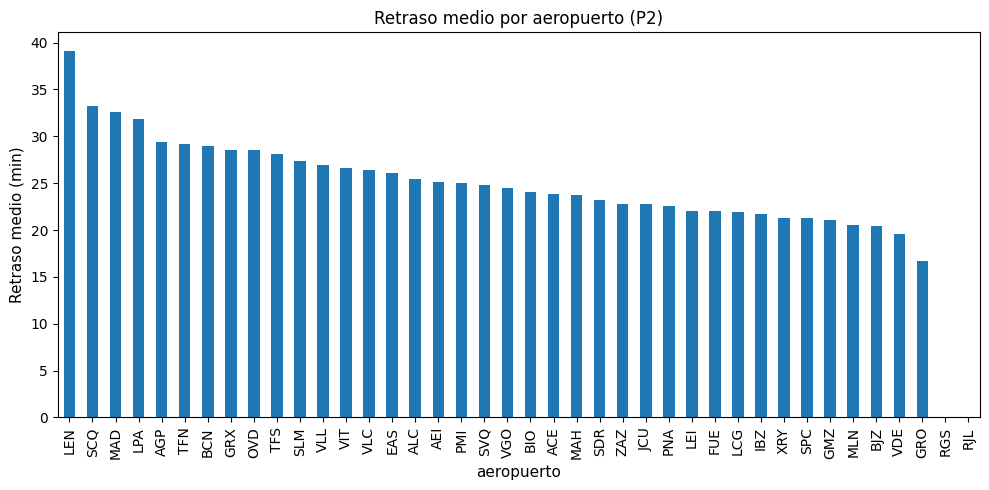

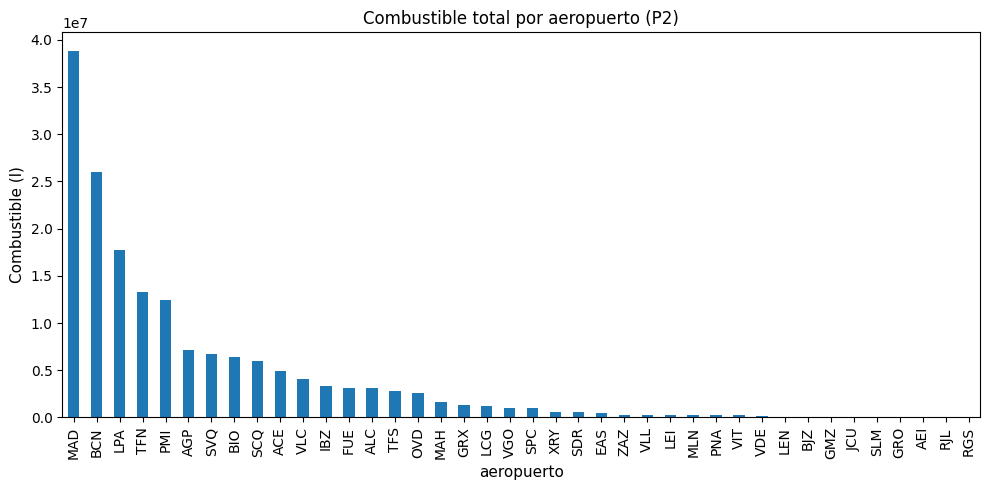

In [303]:
df_aerop['trafico_total'] = df_aerop.get('vuelos_salidas',0)+df_aerop.get('vuelos_llegadas',0)
fig, ax = plt.subplots(); df_aerop.groupby('aeropuerto')['trafico_total'].sum().sort_values(ascending=False).plot(kind='bar', ax=ax)
ax.set_title('Trafico total por aeropuerto (P2)'); ax.set_ylabel('Vuelos'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'trafico_total_por_aeropuerto_p2.png'))
if 'retraso_medio_llegadas_min' in df_aerop.columns:
    fig, ax = plt.subplots(); df_aerop.groupby('aeropuerto')['retraso_medio_llegadas_min'].mean().sort_values(ascending=False).plot(kind='bar', ax=ax)
    ax.set_title('Retraso medio por aeropuerto (P2)'); ax.set_ylabel('Retraso medio (min)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'retraso_medio_por_aeropuerto_p2.png'))
if 'combustible_total_l' in df_aerop.columns:
    fig, ax = plt.subplots(); df_aerop.groupby('aeropuerto')['combustible_total_l'].sum().sort_values(ascending=False).plot(kind='bar', ax=ax)
    ax.set_title('Combustible total por aeropuerto (P2)'); ax.set_ylabel('Combustible (l)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'combustible_total_por_aeropuerto_p2.png'))


## 6. Dinamica temporal


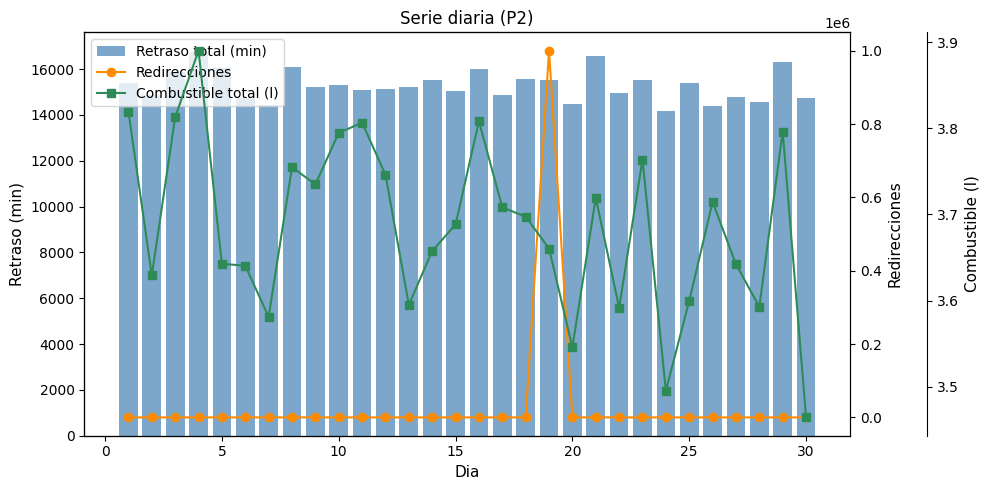

In [304]:
# Serie diaria tres ejes
diario = df_vuelos.groupby('dia').agg(
    retraso_total_min=('retraso_total_min','sum'),
    redirigidos=('redirigido','sum') if 'redirigido' in df_vuelos.columns else ('id_vuelo','size'),
    combustible_total=('combustible_consumido_l','sum') if 'combustible_consumido_l' in df_vuelos.columns else ('id_vuelo','size')
).reset_index()
fig, ax1 = plt.subplots(figsize=(10,5)); ax2 = ax1.twinx(); ax3 = ax1.twinx(); ax3.spines['right'].set_position(('axes',1.1))
bar1 = ax1.bar(diario['dia'], diario['retraso_total_min'], color='steelblue', alpha=0.7, label='Retraso total (min)')
line2, = ax2.plot(diario['dia'], diario['redirigidos'], color='darkorange', marker='o', label='Redirecciones')
line3, = ax3.plot(diario['dia'], diario['combustible_total'], color='seagreen', marker='s', label='Combustible total (l)')
ax1.set_xlabel('Dia'); ax1.set_ylabel('Retraso (min)'); ax2.set_ylabel('Redirecciones'); ax3.set_ylabel('Combustible (l)')
ax1.set_title('Serie diaria (P2)'); ax1.legend([bar1,line2,line3],[h.get_label() for h in [bar1,line2,line3]], loc='upper left')
plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'serie_diaria_retrasos_redir_comb_p2.png'))


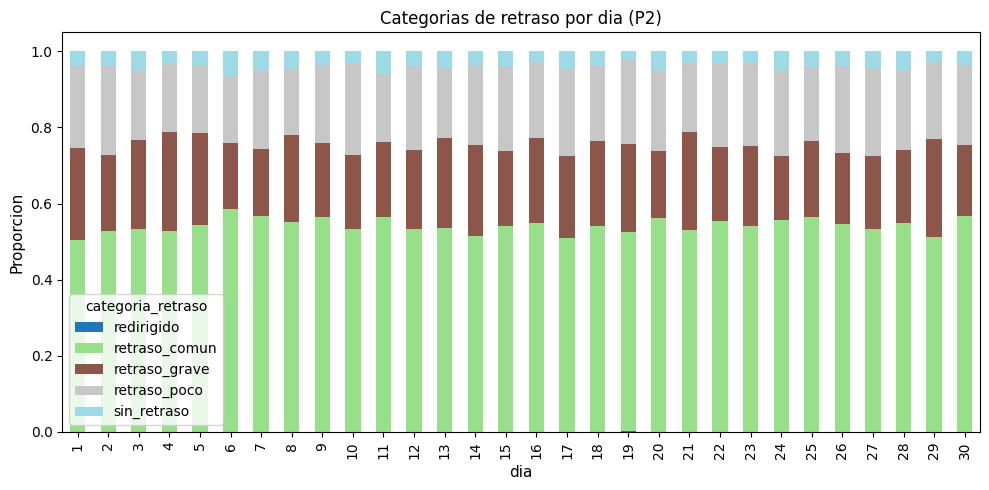

In [305]:
# Stack categorias por dia
if 'categoria_retraso' in df_vuelos.columns:
    cat_day = df_vuelos.pivot_table(index='dia', columns='categoria_retraso', values='id_vuelo', aggfunc='count').fillna(0)
    cat_pct = cat_day.div(cat_day.sum(axis=1), axis=0)
    fig, ax = plt.subplots(figsize=(10,5)); cat_pct.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')
    ax.set_ylabel('Proporcion'); ax.set_title('Categorias de retraso por dia (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'stack_categorias_por_dia_p2.png'))


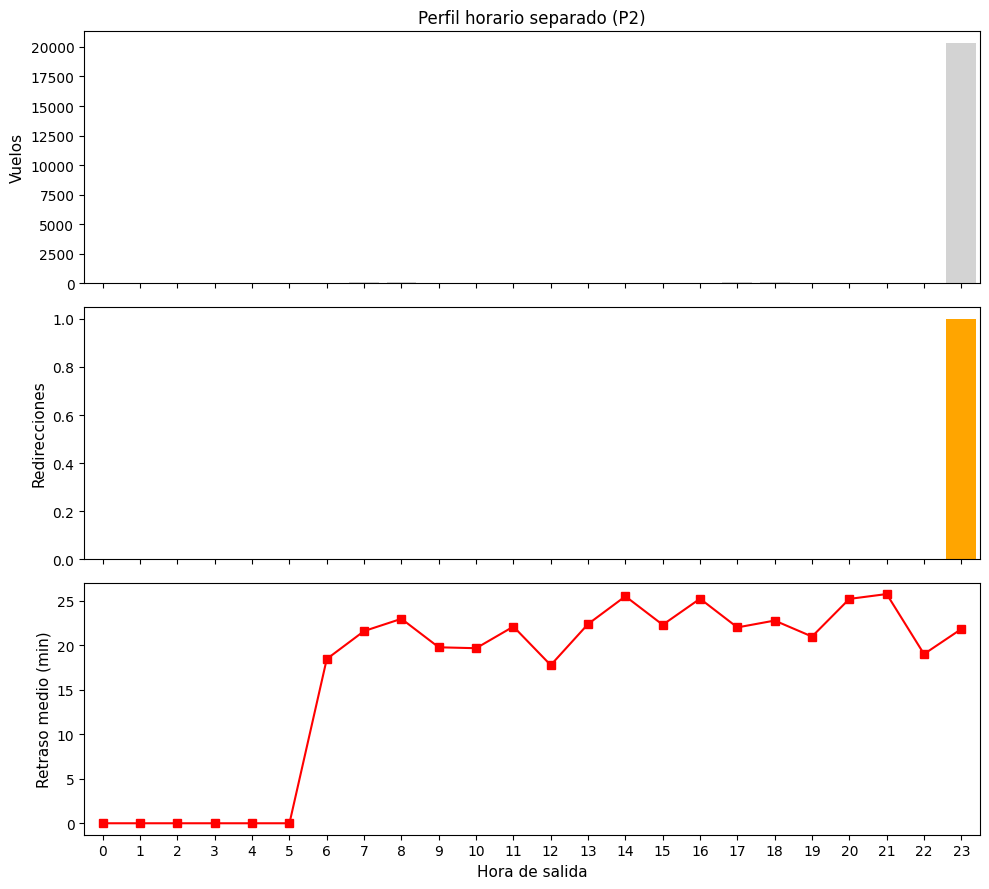

In [306]:
# Perfil horario 3 subplots
if 'hora_salida_h' not in df_vuelos.columns and 'salida_programada' in df_vuelos.columns:
    def hora_from_min(x):
        try: h=int(float(x)//60); return min(max(h,0),23)
        except Exception: return None
    df_vuelos['hora_salida_h'] = df_vuelos['salida_programada'].apply(hora_from_min)
if 'hora_salida_h' in df_vuelos.columns:
    grp = df_vuelos.groupby('hora_salida_h').agg(vuelos=('id_vuelo','count'), redir=('redirigido','sum') if 'redirigido' in df_vuelos.columns else ('id_vuelo','count'), retraso_medio=('retraso_total_min','mean')).reindex(range(24)).fillna(0)
    fig, axes = plt.subplots(3,1, figsize=(10,9), sharex=True)
    axes[0].bar(grp.index, grp['vuelos'], color='lightgray'); axes[0].set_ylabel('Vuelos'); axes[0].set_title('Perfil horario separado (P2)')
    axes[1].bar(grp.index, grp['redir'], color='orange'); axes[1].set_ylabel('Redirecciones')
    axes[2].plot(grp.index, grp['retraso_medio'], color='red', marker='s'); axes[2].set_ylabel('Retraso medio (min)'); axes[2].set_xlabel('Hora de salida'); axes[2].set_xticks(range(24)); axes[2].set_xlim(-0.5,23.5)
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'perfil_horario_salidas_separado_p2.png'))


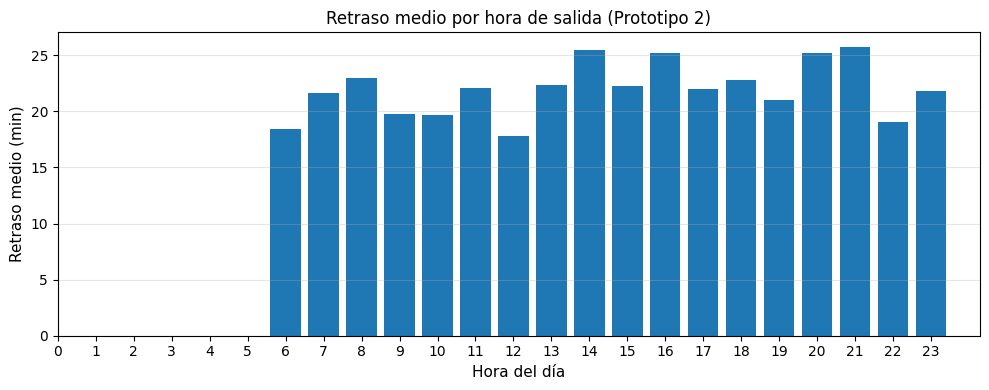

In [307]:
# Heatmap dia-hora

# Retraso medio por hora de salida, agregando todos los días
grupo = df_vuelos.groupby('hora_salida_h')['retraso_total_min'].mean()

# Asegurar que aparezcan todas las horas 0–23 (aunque alguna no tenga vuelos)
horas = np.arange(24)
retraso_medio_hora = grupo.reindex(horas)

# Figura: barra de retraso medio por hora
plt.figure(figsize=(10, 4))
plt.bar(horas, retraso_medio_hora)
plt.xlabel("Hora del día")
plt.ylabel("Retraso medio (min)")
plt.title("Retraso medio por hora de salida (Prototipo 2)")
plt.xticks(horas)
plt.grid(axis="y", alpha=0.3)

# Guarda la figura donde la estás cargando en LaTeX
plt.tight_layout()
plt.savefig(
    "figuras_prototipo2/"
    "retraso_medio_por_hora_p2.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()




## 7. Viento y fases de vuelo


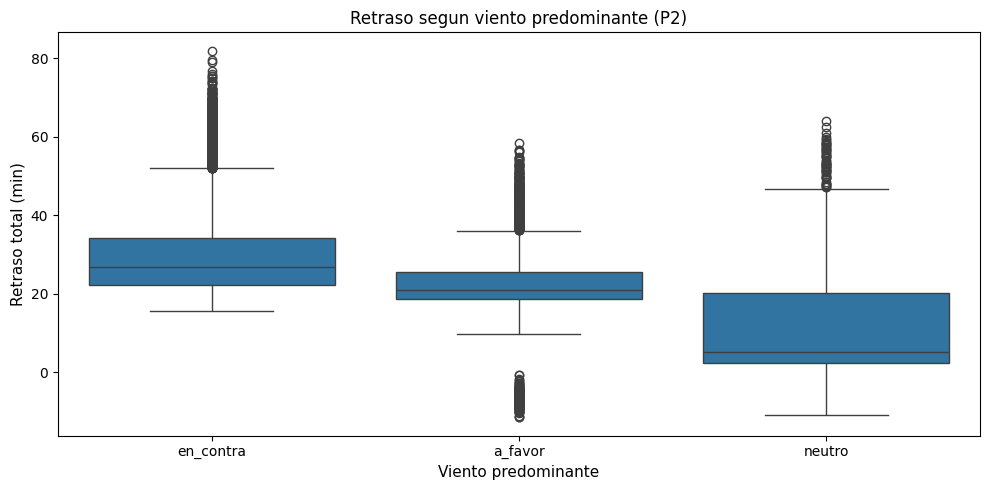

In [308]:
# Viento predominante y retraso
if {'id_vuelo','viento'}.issubset(df_logs.columns):
    viento_pred = df_logs.groupby('id_vuelo')['viento'].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
    df_vuelos['viento_predominante'] = df_vuelos['id_vuelo'].map(viento_pred)
    fig, ax = plt.subplots(); sns.boxplot(data=df_vuelos.dropna(subset=['viento_predominante']), x='viento_predominante', y='retraso_total_min', ax=ax)
    ax.set_xlabel('Viento predominante'); ax.set_ylabel('Retraso total (min)'); ax.set_title('Retraso segun viento predominante (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'box_retraso_por_viento_p2.png'))


C:\Users\alvar\AppData\Local\Temp\ipykernel_12932\2215684762.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = df_vuelos.copy(); df_temp['bin_retraso'] = pd.qcut(df_temp['retraso_total_min'], q=10, duplicates='drop'); prob_bin = df_temp.groupby('bin_retraso')['redirigido'].mean()


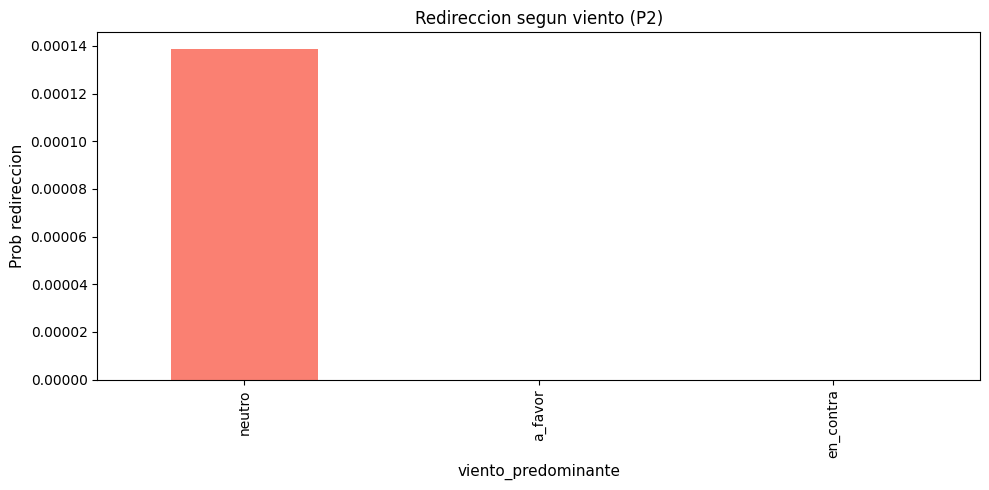

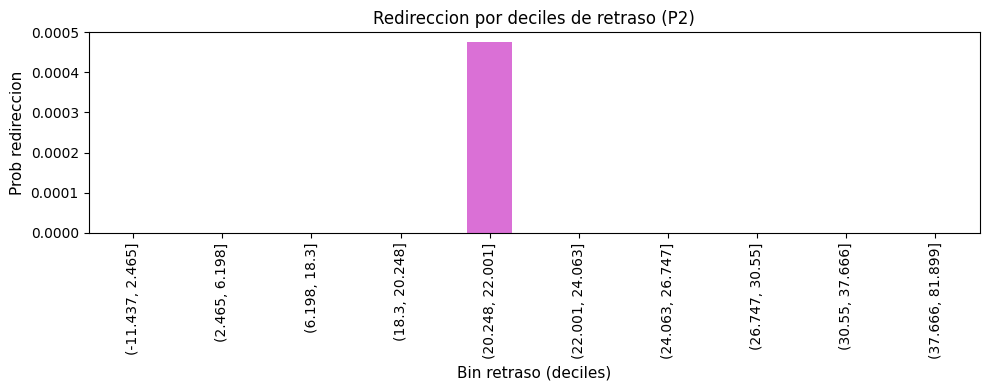

In [309]:
# Prob redireccion por viento y por deciles de retraso
if 'redirigido' in df_vuelos.columns and 'viento_predominante' in df_vuelos.columns:
    prob = df_vuelos.groupby('viento_predominante')['redirigido'].mean().dropna().sort_values(ascending=False)
    fig, ax = plt.subplots(); prob.plot(kind='bar', ax=ax, color='salmon'); ax.set_ylabel('Prob redireccion'); ax.set_title('Redireccion segun viento (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'prob_redir_por_viento_p2.png'))
if 'redirigido' in df_vuelos.columns:
    df_temp = df_vuelos.copy(); df_temp['bin_retraso'] = pd.qcut(df_temp['retraso_total_min'], q=10, duplicates='drop'); prob_bin = df_temp.groupby('bin_retraso')['redirigido'].mean()
    fig, ax = plt.subplots(figsize=(10,4)); prob_bin.plot(kind='bar', ax=ax, color='orchid'); ax.set_ylabel('Prob redireccion'); ax.set_xlabel('Bin retraso (deciles)'); ax.set_title('Redireccion por deciles de retraso (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'prob_redir_por_retraso_bins_p2.png'))


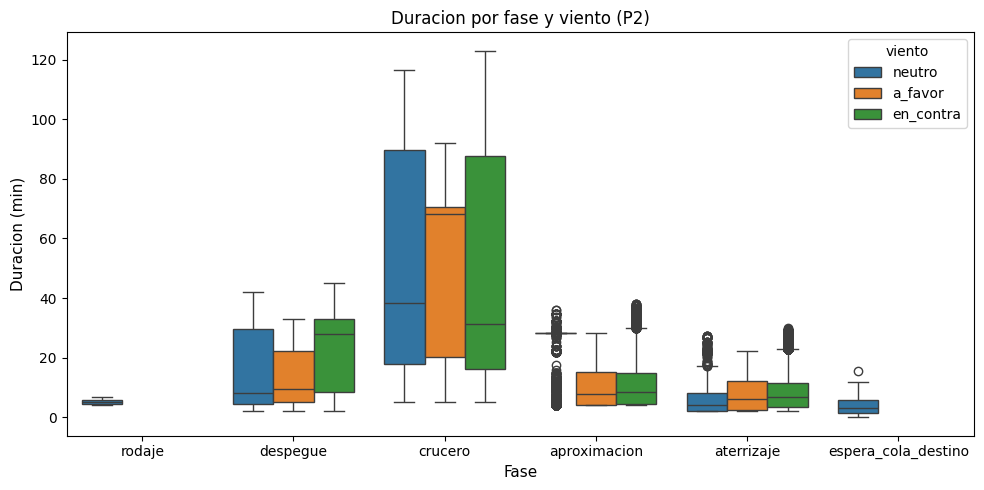

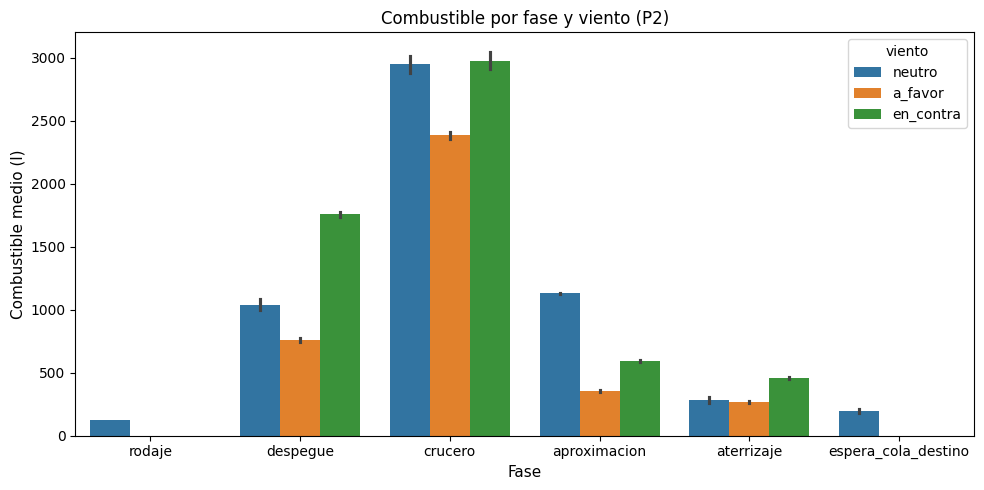

In [310]:
# Viento por fase: duracion y combustible
if {'fase','viento'}.issubset(df_logs.columns):
    if 'duracion_min' not in df_logs.columns and {'minuto_inicio','minuto_fin'}.issubset(df_logs.columns):
        df_logs['duracion_min'] = df_logs['minuto_fin'] - df_logs['minuto_inicio']
    if 'duracion_min' in df_logs.columns:
        fig, ax = plt.subplots(figsize=(10,5)); sns.boxplot(data=df_logs, x='fase', y='duracion_min', hue='viento', ax=ax)
        ax.set_xlabel('Fase'); ax.set_ylabel('Duracion (min)'); ax.set_title('Duracion por fase y viento (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'box_duracion_fase_viento_p2.png'))
    if 'combustible_consumido_l' in df_logs.columns:
        fig, ax = plt.subplots(figsize=(10,5)); sns.barplot(data=df_logs, x='fase', y='combustible_consumido_l', hue='viento', estimator=np.mean, ax=ax)
        ax.set_xlabel('Fase'); ax.set_ylabel('Combustible medio (l)'); ax.set_title('Combustible por fase y viento (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'bar_combustible_fase_viento_p2.png'))


## 8. Distancia, combustible y redirecciones


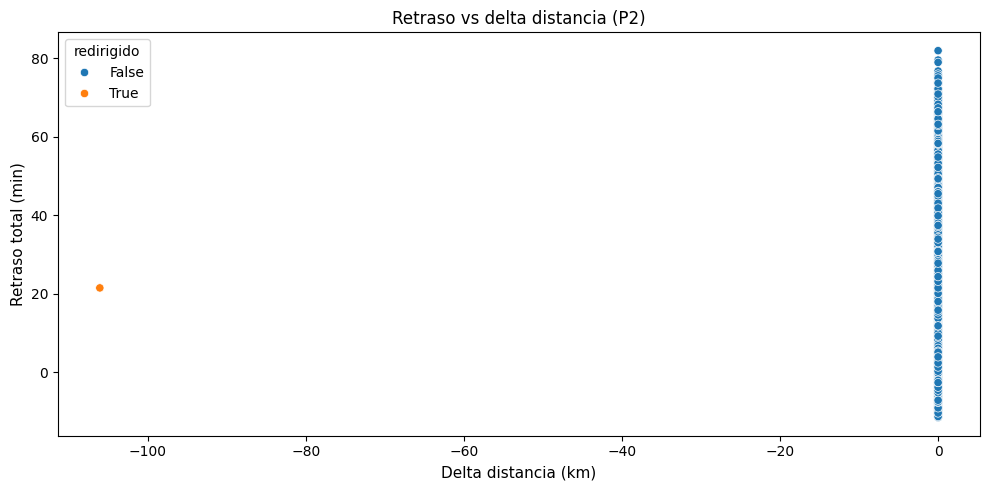

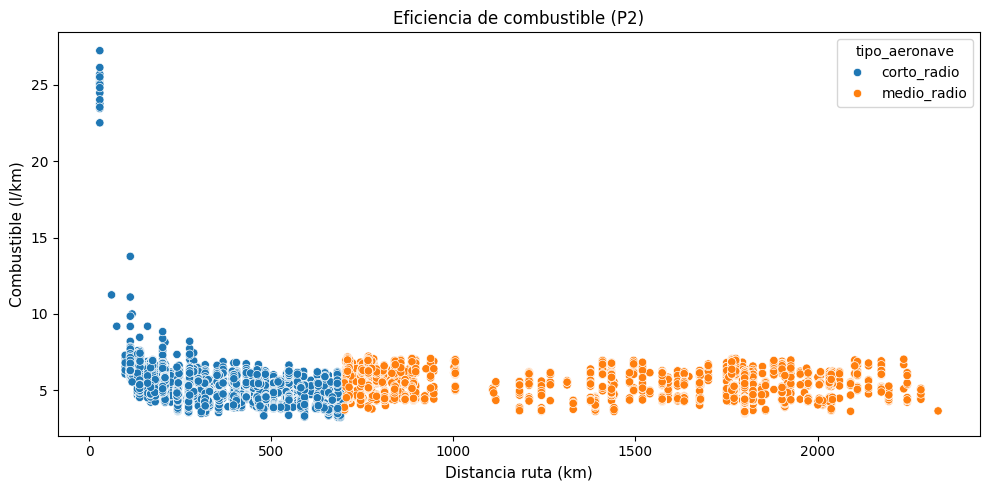

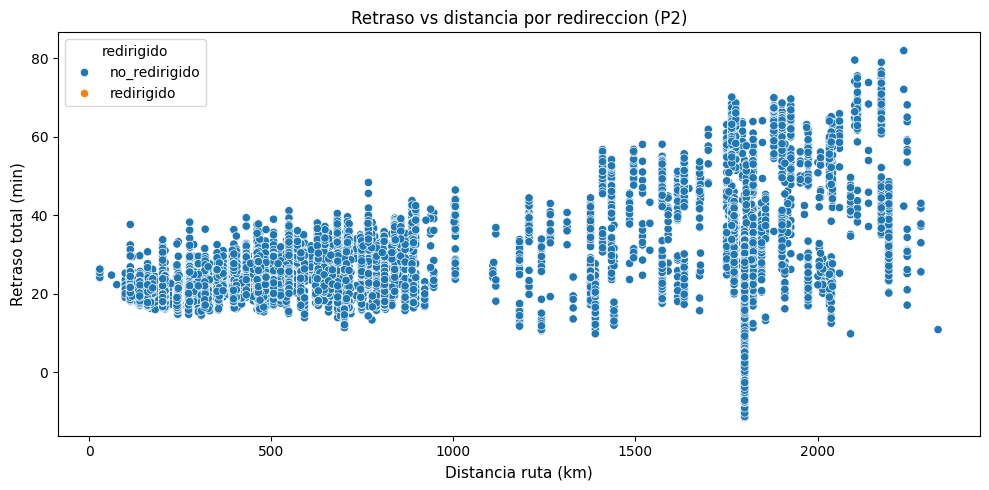

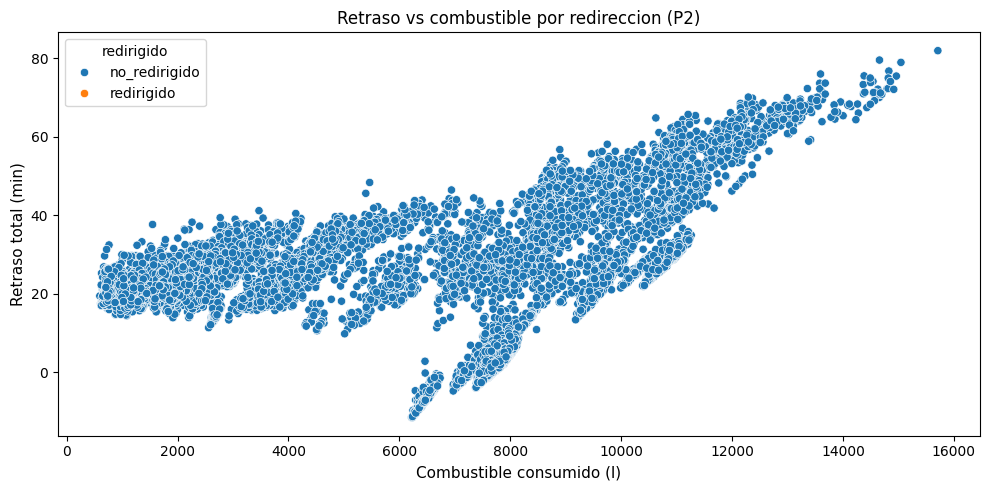

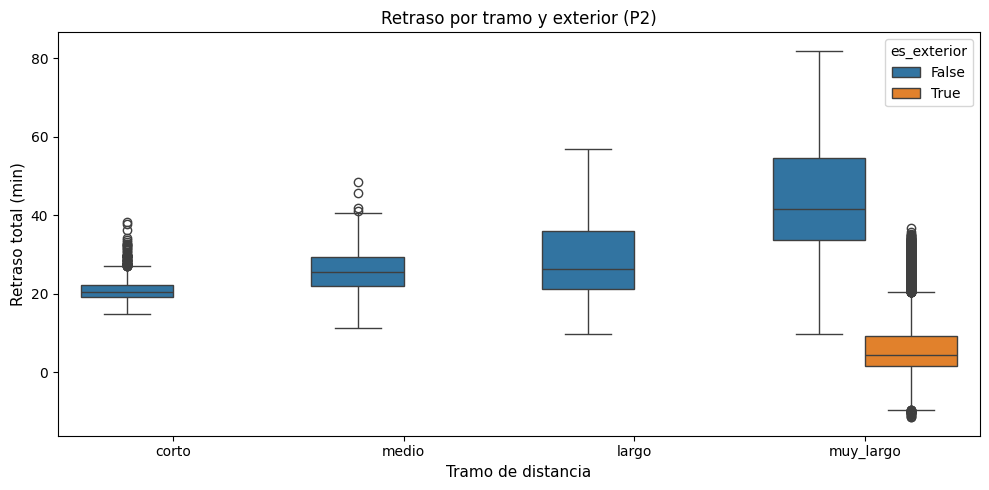

In [311]:
# Delta distancia y retraso
if {'distancia_ruta_km','distancia_plan_km'}.issubset(df_vuelos.columns):
    df_vuelos['delta_dist_km'] = df_vuelos['distancia_ruta_km'] - df_vuelos['distancia_plan_km']
    fig, ax = plt.subplots(); sns.scatterplot(data=df_vuelos, x='delta_dist_km', y='retraso_total_min', hue=df_vuelos.get('redirigido', None), ax=ax)
    ax.set_xlabel('Delta distancia (km)'); ax.set_ylabel('Retraso total (min)'); ax.set_title('Retraso vs delta distancia (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'scatter_retraso_delta_dist_p2.png'))

# Eficiencia combustible
if {'combustible_consumido_l','distancia_ruta_km'}.issubset(df_vuelos.columns):
    df_vuelos['comb_lkm'] = df_vuelos['combustible_consumido_l']/df_vuelos['distancia_ruta_km'].replace(0,np.nan)
    fig, ax = plt.subplots(); sns.scatterplot(data=df_vuelos, x='distancia_ruta_km', y='comb_lkm', hue=df_vuelos.get('tipo_aeronave', None), ax=ax)
    ax.set_xlabel('Distancia ruta (km)'); ax.set_ylabel('Combustible (l/km)'); ax.set_title('Eficiencia de combustible (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'scatter_eficiencia_combustible_p2.png'))

# Retraso vs distancia/combustible por redireccion
redir_series = df_vuelos['redirigido'] if 'redirigido' in df_vuelos.columns else pd.Series(False, index=df_vuelos.index)
fig, ax = plt.subplots(); sns.scatterplot(data=df_vuelos, x='distancia_ruta_km', y='retraso_total_min', hue=redir_series.map({True:'redirigido', False:'no_redirigido'}), ax=ax)
ax.set_xlabel('Distancia ruta (km)'); ax.set_ylabel('Retraso total (min)'); ax.set_title('Retraso vs distancia por redireccion (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'scatter_retraso_distancia_redir_p2.png'))
fig, ax = plt.subplots(); sns.scatterplot(data=df_vuelos, x='combustible_consumido_l', y='retraso_total_min', hue=redir_series.map({True:'redirigido', False:'no_redirigido'}), ax=ax)
ax.set_xlabel('Combustible consumido (l)'); ax.set_ylabel('Retraso total (min)'); ax.set_title('Retraso vs combustible por redireccion (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'scatter_retraso_combustible_redir_p2.png'))

# Tramos de distancia y exterior
bins = [0,300,800,1500,10000]; labels = ['corto','medio','largo','muy_largo']
if 'distancia_ruta_km' in df_vuelos.columns:
    df_vuelos['tramo_dist'] = pd.cut(df_vuelos['distancia_ruta_km'], bins=bins, labels=labels, include_lowest=True)
    fig, ax = plt.subplots(figsize=(10,5)); sns.boxplot(data=df_vuelos, x='tramo_dist', y='retraso_total_min', hue=df_vuelos.get('es_exterior', None), ax=ax)
    ax.set_xlabel('Tramo de distancia'); ax.set_ylabel('Retraso total (min)'); ax.set_title('Retraso por tramo y exterior (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'retraso_tramo_dist_exterior_p2.png'))


## 9. Congestion y eventos


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


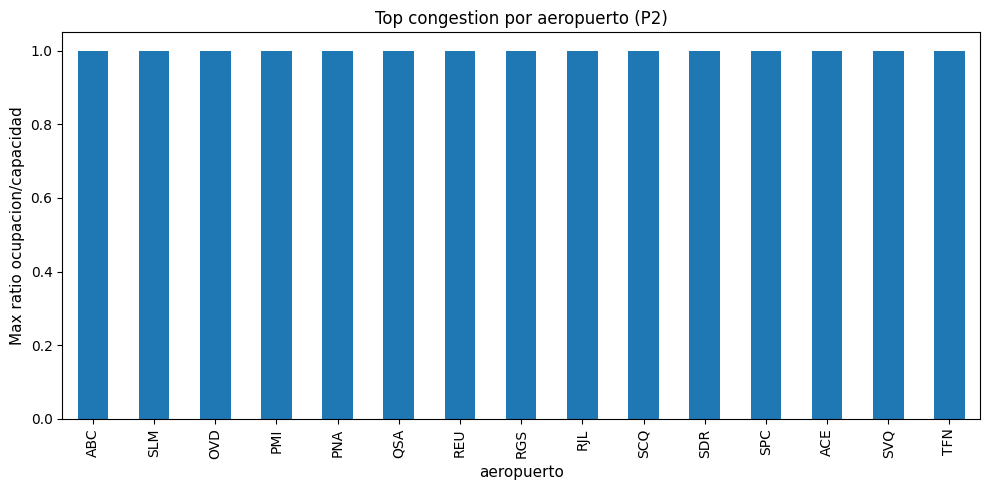

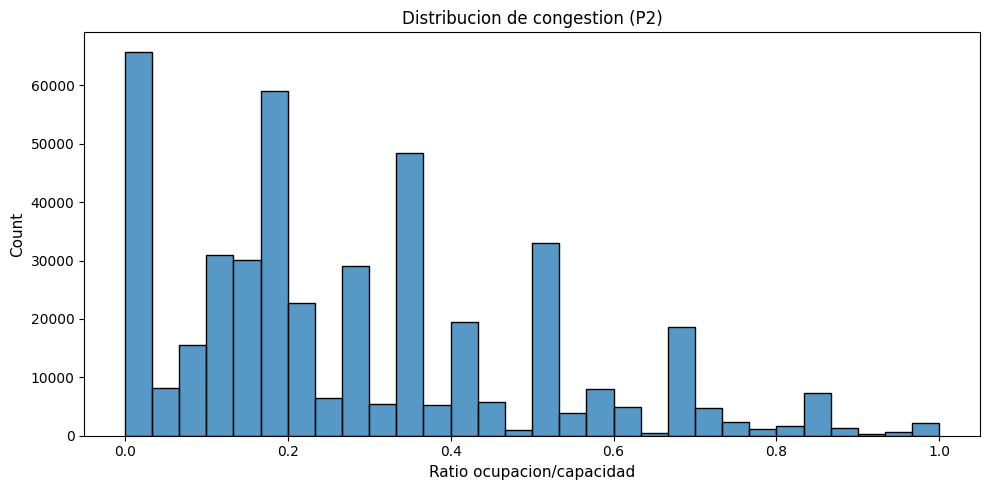

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


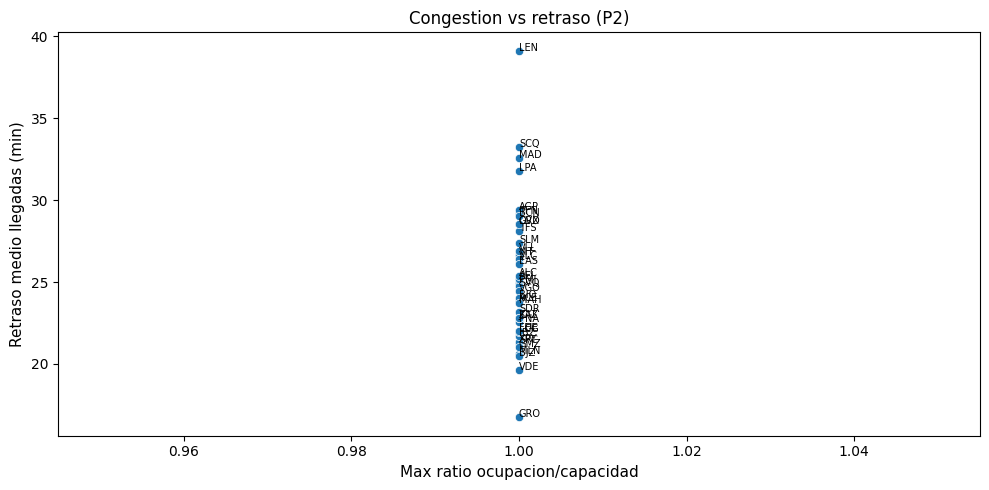

In [312]:
if {'ocupacion','capacidad','aeropuerto'}.issubset(df_eventos.columns):
    df_eventos['ratio'] = df_eventos['ocupacion']/df_eventos['capacidad'].replace(0,np.nan)
    ratio_max = df_eventos.groupby('aeropuerto')['ratio'].max().sort_values(ascending=False)
    fig, ax = plt.subplots(); ratio_max.head(15).plot(kind='bar', ax=ax); ax.set_ylabel('Max ratio ocupacion/capacidad'); ax.set_title('Top congestion por aeropuerto (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'top_congestion_aeropuertos_p2.png'))
    fig, ax = plt.subplots(); sns.histplot(df_eventos['ratio'].dropna(), bins=30, ax=ax); ax.set_xlabel('Ratio ocupacion/capacidad'); ax.set_title('Distribucion de congestion (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'hist_congestion_p2.png'))
    if 'retraso_medio_llegadas_min' in df_aerop.columns:
        retraso_aer = df_aerop.groupby('aeropuerto')['retraso_medio_llegadas_min'].mean(); common = ratio_max.index.intersection(retraso_aer.index); comp = pd.DataFrame({'ratio_max': ratio_max.loc[common], 'retraso_medio': retraso_aer.loc[common]})
        fig, ax = plt.subplots(); sns.scatterplot(data=comp, x='ratio_max', y='retraso_medio', ax=ax)
        for a,row in comp.iterrows(): ax.text(row['ratio_max'], row['retraso_medio'], a, fontsize=7)
        ax.set_xlabel('Max ratio ocupacion/capacidad'); ax.set_ylabel('Retraso medio llegadas (min)'); ax.set_title('Congestion vs retraso (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'scatter_congestion_retraso_aeropuerto_p2.png'))


## 10. Exterior vs interior, adelantados y casos especiales


Vuelos adelantados: 846


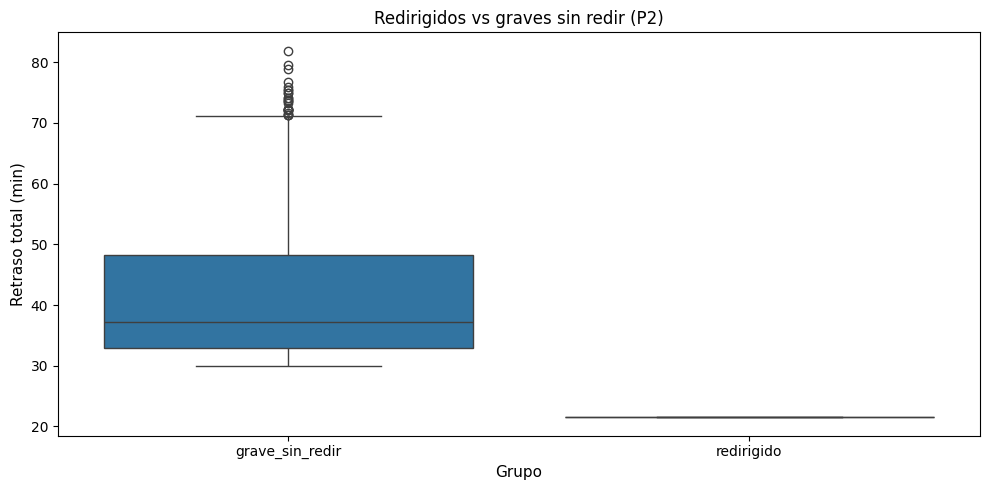

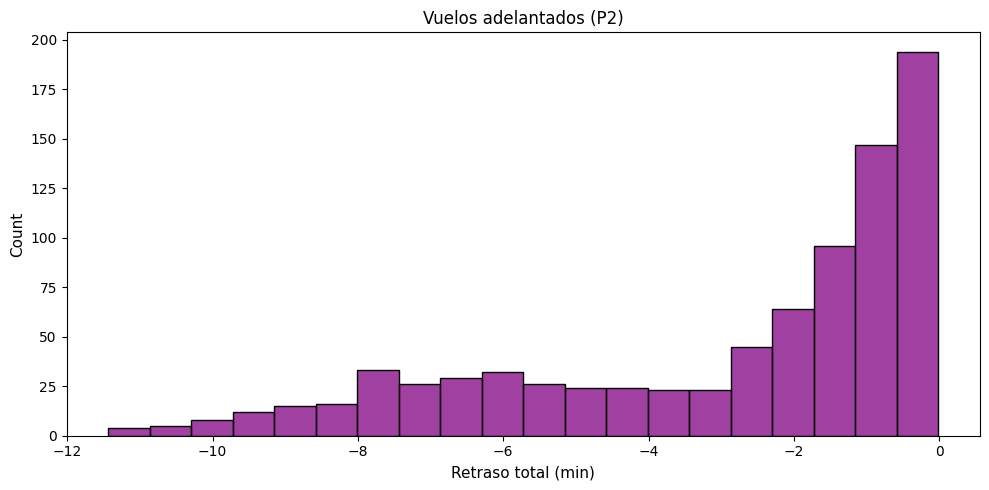

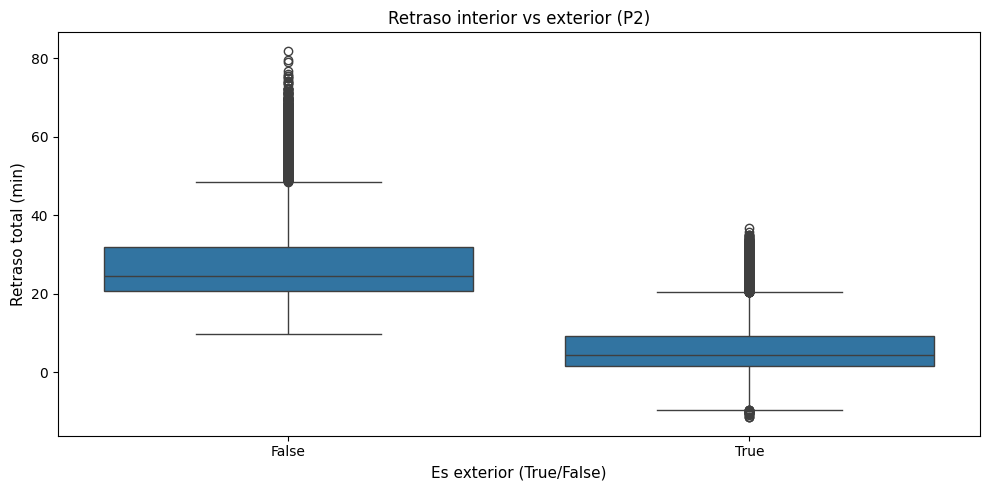

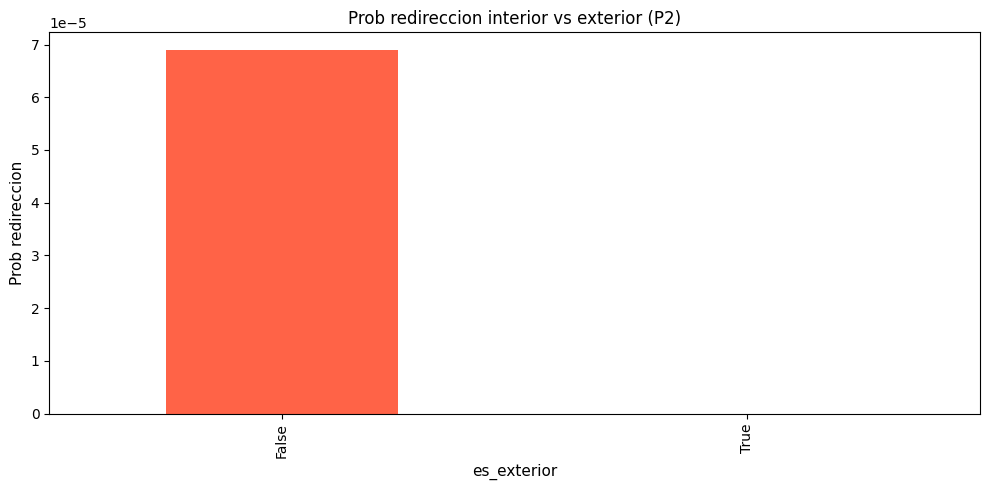

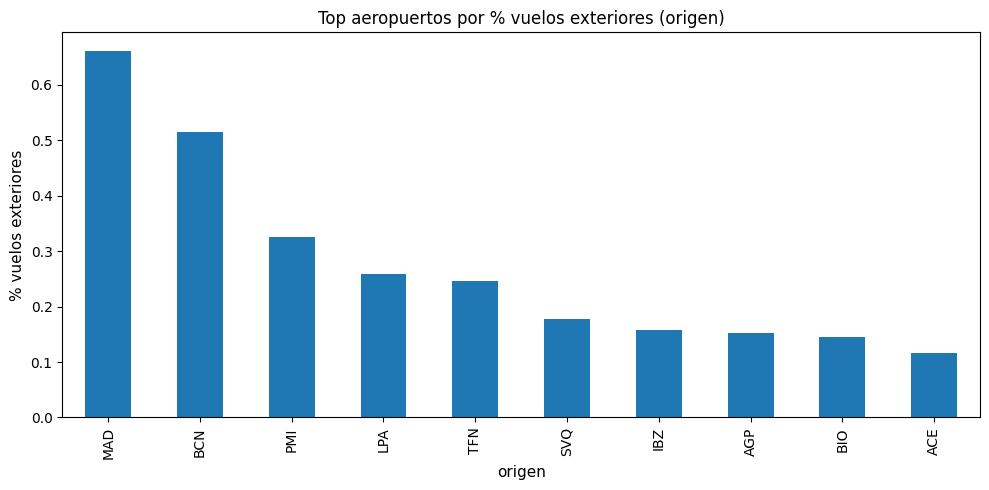

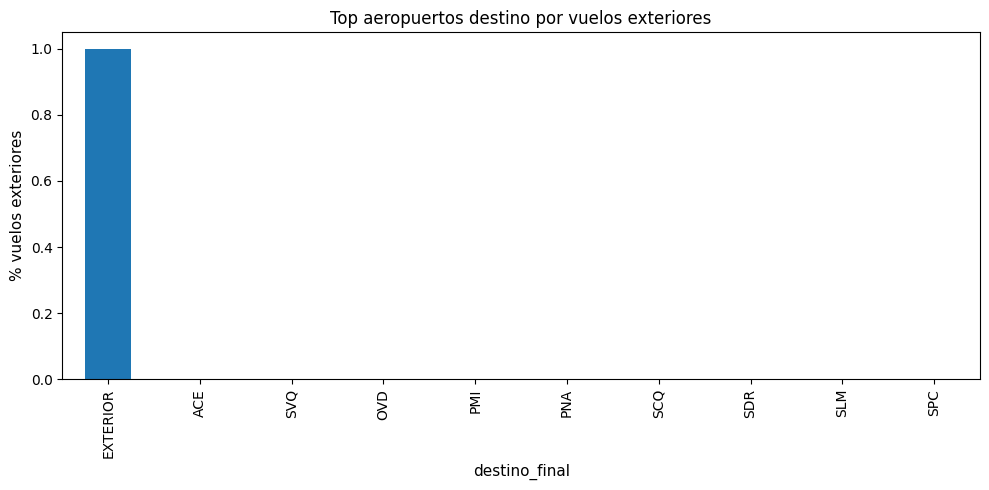

In [313]:
col_delay='retraso_total_min'
redir_mask = df_vuelos.get('redirigido', pd.Series(False, index=df_vuelos.index)).astype(bool)
grave_no_redir = (~redir_mask) & (df_vuelos[col_delay]>30)
comp_df = pd.DataFrame({'grupo': np.select([redir_mask, grave_no_redir], ['redirigido','grave_sin_redir'], default='otros'), col_delay: df_vuelos[col_delay]})
comp_df = comp_df[comp_df['grupo']!='otros']
if not comp_df.empty:
    fig, ax = plt.subplots(); sns.boxplot(data=comp_df, x='grupo', y=col_delay, ax=ax); ax.set_xlabel('Grupo'); ax.set_ylabel('Retraso total (min)'); ax.set_title('Redirigidos vs graves sin redir (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'box_redir_vs_grave_p2.png'))

adelantados = df_vuelos[df_vuelos[col_delay] < 0]; print('Vuelos adelantados:', len(adelantados))
if not adelantados.empty:
    fig, ax = plt.subplots(); sns.histplot(adelantados[col_delay], bins=20, color='purple', ax=ax); ax.set_xlabel('Retraso total (min)'); ax.set_title('Vuelos adelantados (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'hist_vuelos_adelantados_p2.png'))

if 'es_exterior' in df_vuelos.columns:
    fig, ax = plt.subplots(); sns.boxplot(data=df_vuelos, x='es_exterior', y=col_delay, ax=ax); ax.set_xlabel('Es exterior (True/False)'); ax.set_ylabel('Retraso total (min)'); ax.set_title('Retraso interior vs exterior (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'box_retraso_exterior_p2.png'))
    if 'redirigido' in df_vuelos.columns:
        rates = df_vuelos.groupby('es_exterior')['redirigido'].mean(); fig, ax = plt.subplots(); rates.plot(kind='bar', ax=ax, color='tomato'); ax.set_ylabel('Prob redireccion'); ax.set_title('Prob redireccion interior vs exterior (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'prob_redir_exterior_p2.png'))

if 'es_exterior' in df_vuelos.columns:
    fig, ax = plt.subplots(); df_vuelos.groupby('origen')['es_exterior'].mean().sort_values(ascending=False).head(10).plot(kind='bar', ax=ax); ax.set_ylabel('% vuelos exteriores'); ax.set_title('Top aeropuertos por % vuelos exteriores (origen)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'exterior_por_aeropuerto_origen_p2.png'))
    dest_col = 'destino_final' if 'destino_final' in df_vuelos.columns else 'destino_programado'
    fig, ax = plt.subplots(); df_vuelos.groupby(dest_col)['es_exterior'].mean().sort_values(ascending=False).head(10).plot(kind='bar', ax=ax); ax.set_ylabel('% vuelos exteriores'); ax.set_title('Top aeropuertos destino por vuelos exteriores'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'exterior_por_aeropuerto_destino_p2.png'))


## 11. Flujos reales vs trafico simulado


Aeropuertos en comun: 40 | Correlacion flow vs trafico: 0.999


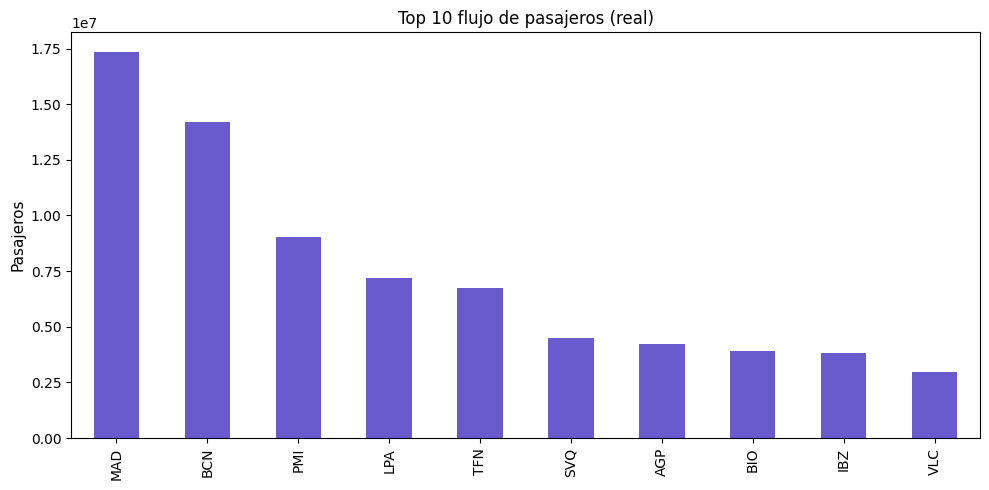

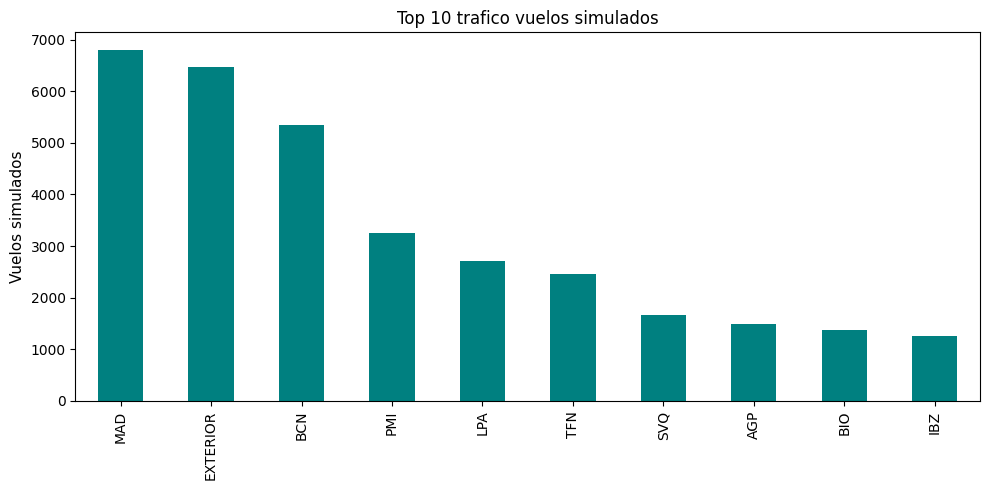

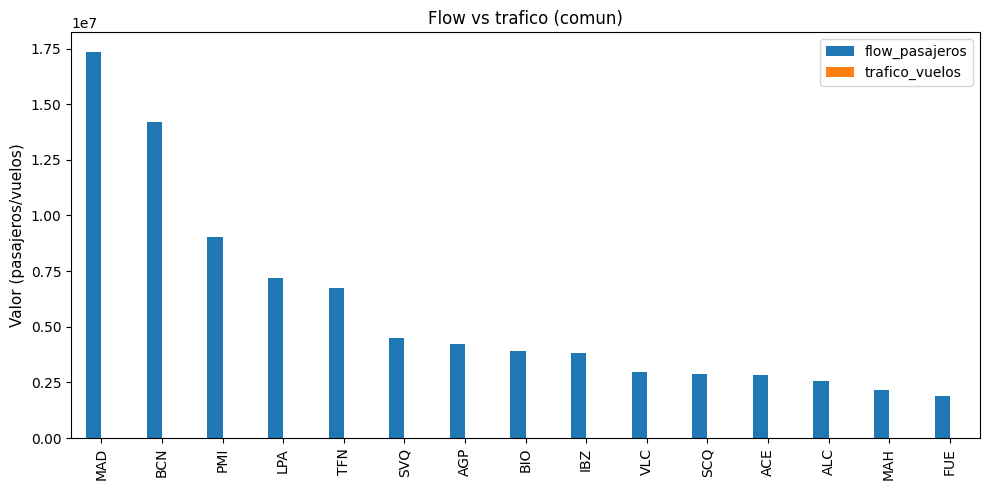

In [314]:
flujo_path = os.path.join(FUENTES_DIR, 'Flujo_Aeropuertos_Espanoles.csv')
if os.path.exists(flujo_path):
    flows = pd.read_csv(flujo_path)
    def code_from(cell):
        if pd.isna(cell): return None
        return str(cell).split(':')[0].strip()
    flows['origen_code'] = flows['Aeropuerto_Origen'].apply(code_from)
    flows['destino_code'] = flows['Aeropuerto_Destino'].apply(code_from)
    flows['pasajeros_num'] = flows['Pasajeros'].apply(lambda x: float(str(x).replace('.','').replace(',','')) if pd.notna(x) else 0)
    flow_out = flows.groupby('origen_code')['pasajeros_num'].sum(); flow_in = flows.groupby('destino_code')['pasajeros_num'].sum(); flow_total = flow_out.add(flow_in, fill_value=0).sort_values(ascending=False)
    traf_sim = df_vuelos.groupby('origen')['id_vuelo'].count().add(df_vuelos.groupby('destino_final')['id_vuelo'].count(), fill_value=0).sort_values(ascending=False)
    common = flow_total.index.intersection(traf_sim.index)
    inter_df = pd.DataFrame({'flow_pasajeros': flow_total.loc[common], 'trafico_vuelos': traf_sim.loc[common]}).sort_values('flow_pasajeros', ascending=False)
    corr = inter_df.corr().iloc[0,1] if len(inter_df)>1 else np.nan
    print(f'Aeropuertos en comun: {len(common)} | Correlacion flow vs trafico: {corr:.3f}')
    fig, ax = plt.subplots(); flow_total.head(10).plot(kind='bar', ax=ax, color='slateblue'); ax.set_ylabel('Pasajeros'); ax.set_title('Top 10 flujo de pasajeros (real)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'top_flujo_pasajeros_p2.png'))
    fig, ax = plt.subplots(); traf_sim.head(10).plot(kind='bar', ax=ax, color='teal'); ax.set_ylabel('Vuelos simulados'); ax.set_title('Top 10 trafico vuelos simulados'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'top_trafico_simulado_p2.png'))
    if not inter_df.empty:
        fig, ax = plt.subplots(); inter_df.head(15).plot(kind='bar', ax=ax); ax.set_ylabel('Valor (pasajeros/vuelos)'); ax.set_title('Flow vs trafico (comun)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'flow_vs_trafico_comun_p2.png'))
else:
    print('No se encontro Flujo_Aeropuertos_Espanoles.csv')


## 12. Correlaciones y modelo simple


                         retraso_total_min  combustible_consumido_l  \
retraso_total_min                 1.000000                 0.129037   
combustible_consumido_l           0.129037                 1.000000   
distancia_ruta_km                -0.123797                 0.958142   
tiempo_total_min                  0.149348                 0.989762   
tiempo_rodaje_min                 0.066584                -0.001597   
tiempo_despegue_min              -0.145745                 0.939146   
tiempo_crucero_min                0.062694                 0.989300   
tiempo_aproximacion_min          -0.112606                 0.954057   
tiempo_aterrizaje_min             0.783609                 0.325855   

                         distancia_ruta_km  tiempo_total_min  \
retraso_total_min                -0.123797          0.149348   
combustible_consumido_l           0.958142          0.989762   
distancia_ruta_km                 1.000000          0.962678   
tiempo_total_min                 

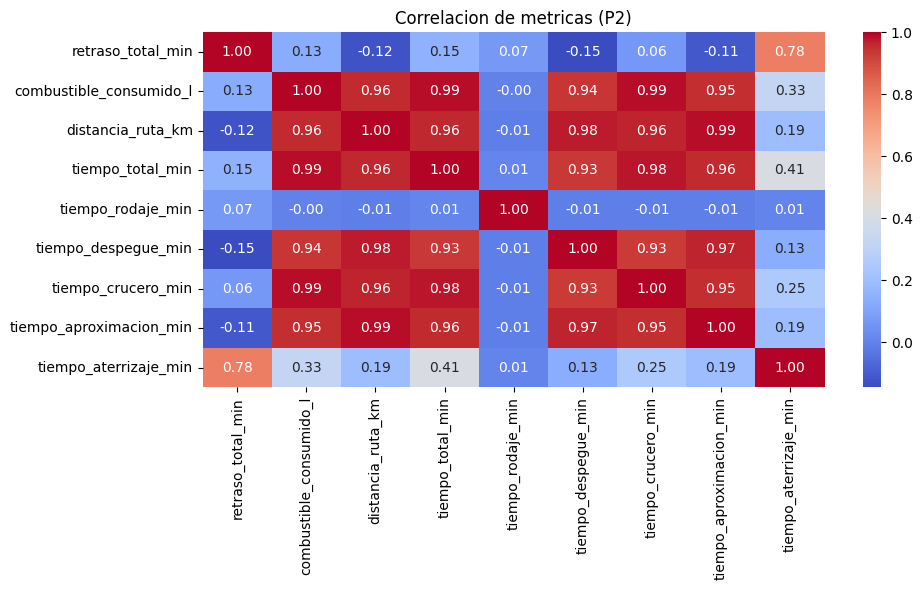

In [315]:
cols_corr = [c for c in ['retraso_total_min','combustible_consumido_l','distancia_ruta_km','tiempo_total_min','tiempo_rodaje_min','tiempo_despegue_min','tiempo_crucero_min','tiempo_aproximacion_min','tiempo_aterrizaje_min'] if c in df_vuelos.columns]
if len(cols_corr) >= 2:
    corr = df_vuelos[cols_corr].corr(); print(corr)
    fig, ax = plt.subplots(figsize=(10,6)); sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax); ax.set_title('Correlacion de metricas (P2)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'corr_matriz_p2.png'))


R2: 1.0
Intercepto: -0.26861347305221206
Coef distancia_ruta_km: -0.0743
Coef combustible_consumido_l: 0.0001
Coef tiempo_total_min: 0.9829
Coef tiempo_crucero_min: 0.0084
Coef tiempo_aproximacion_min: 0.0157


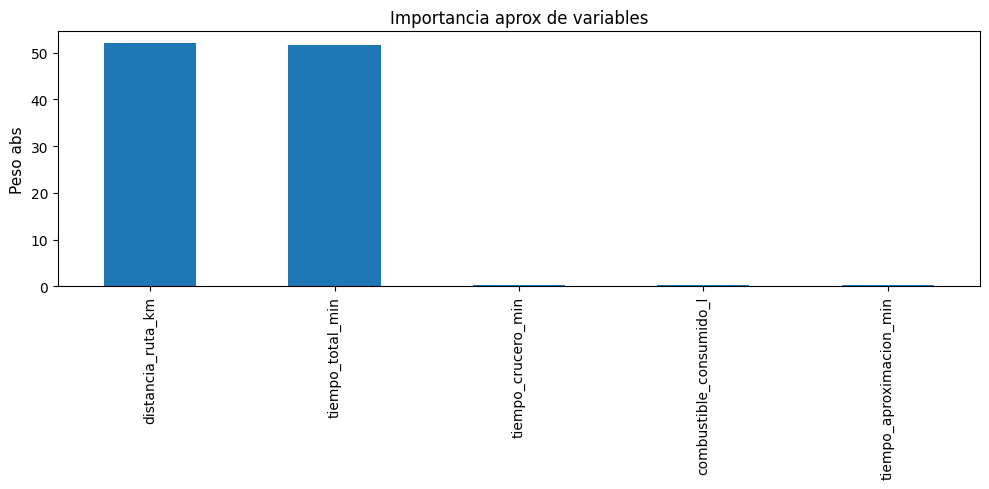

In [316]:
cols_modelo = [c for c in ['distancia_ruta_km','combustible_consumido_l','tiempo_total_min','tiempo_crucero_min','tiempo_aproximacion_min'] if c in df_vuelos.columns]
objetivo = 'retraso_total_min'
if cols_modelo and objetivo in df_vuelos.columns:
    df_tmp = df_vuelos[[objetivo]+cols_modelo].dropna()
    if len(df_tmp) > 10:
        X = df_tmp[cols_modelo].values; y = df_tmp[objetivo].values; X_design = np.column_stack([np.ones(len(X)), X]); coef, *_ = np.linalg.lstsq(X_design, y, rcond=None); y_pred = X_design@coef; ss_res = ((y-y_pred)**2).sum(); ss_tot = ((y-y.mean())**2).sum(); r2 = 1-ss_res/ss_tot if ss_tot!=0 else np.nan
        print('R2:', round(r2,3)); print('Intercepto:', coef[0]);
        for n,c in zip(cols_modelo, coef[1:]): print(f'Coef {n}: {c:.4f}')
        X_std = (X - X.mean(axis=0))/X.std(axis=0); coef_std, *_ = np.linalg.lstsq(np.column_stack([np.ones(len(X_std)), X_std]), y, rcond=None); contrib = pd.Series({n: abs(c) for n,c in zip(cols_modelo, coef_std[1:])}).sort_values(ascending=False)
        fig, ax = plt.subplots(); contrib.plot(kind='bar', ax=ax); ax.set_ylabel('Peso abs'); ax.set_title('Importancia aprox de variables'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'importancia_lineal_retraso_p2.png'))
    else:
        print('No hay suficientes filas para modelo lineal')
else:
    print('Columnas para modelo lineal no disponibles')


## 13. Resumen auto generado


In [317]:
resumen = {}
col_delay='retraso_total_min'
if col_delay in df_vuelos.columns:
    resumen['retraso_media'] = df_vuelos[col_delay].mean(); resumen['retraso_p90'] = df_vuelos[col_delay].quantile(0.9); resumen['retraso_p95'] = df_vuelos[col_delay].quantile(0.95); resumen['pct_retraso_grave'] = (df_vuelos[col_delay]>30).mean()*100
if 'redirigido' in df_vuelos.columns: resumen['pct_redir'] = df_vuelos['redirigido'].mean()*100
if 'combustible_consumido_l' in df_vuelos.columns: resumen['comb_total_Ml'] = df_vuelos['combustible_consumido_l'].sum()/1e6
if 'es_exterior' in df_vuelos.columns: resumen['pct_exterior'] = df_vuelos['es_exterior'].mean()*100
print('--- Resumen rapido ---')
for k,v in resumen.items(): print(f"{k}: {v:.2f}")


--- Resumen rapido ---
retraso_media: 21.84
retraso_p90: 37.67
retraso_p95: 49.22
pct_retraso_grave: 21.10
pct_redir: 0.00
comb_total_Ml: 110.60
pct_exterior: 30.85


### Redirecciones por aeropuerto (refugio vs problema)
Top 5 aeropuertos que reciben redirecciones (refugio) y top 5 que expulsan (problema).


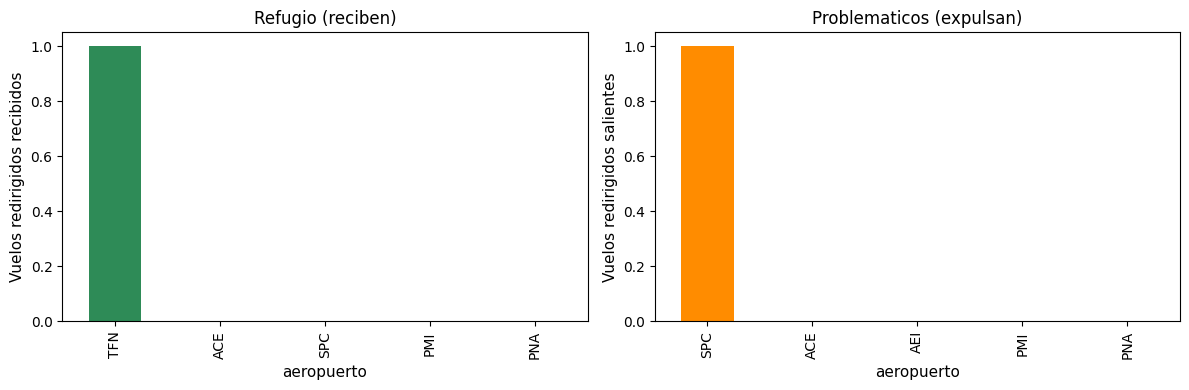

In [318]:
if {'vuelos_redirigidos_salientes','vuelos_redirigidos_recibidos'}.issubset(df_aerop.columns):
    aerop_redir = df_aerop.groupby('aeropuerto')[['vuelos_redirigidos_salientes','vuelos_redirigidos_recibidos']].sum()
    top_rec = aerop_redir['vuelos_redirigidos_recibidos'].sort_values(ascending=False).head(5)
    top_sal = aerop_redir['vuelos_redirigidos_salientes'].sort_values(ascending=False).head(5)
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    top_rec.plot(kind='bar', ax=ax[0], color='seagreen'); ax[0].set_title('Refugio (reciben)'); ax[0].set_ylabel('Vuelos redirigidos recibidos')
    top_sal.plot(kind='bar', ax=ax[1], color='darkorange'); ax[1].set_title('Problematicos (expulsan)'); ax[1].set_ylabel('Vuelos redirigidos salientes')
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'top_redir_refugio_vs_problema_p2.png'))
else:
    print('No hay columnas de redirecciones por aeropuerto')


### Evolucion diaria ampliada
Retraso medio, vuelos con retraso grave (>30), redirecciones y combustible por dia.


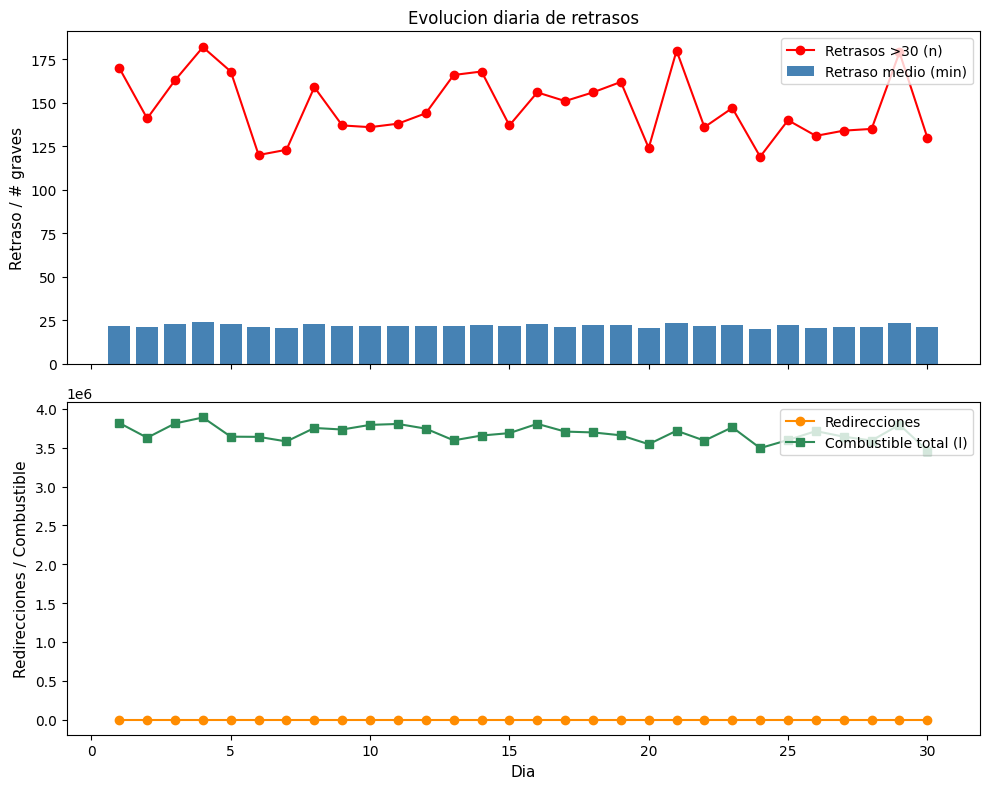

In [319]:
diario_ext = df_vuelos.groupby('dia').agg(
    retraso_medio=('retraso_total_min','mean'),
    retrasos_graves=('retraso_total_min', lambda s: (s>30).sum()),
    redirigidos=('redirigido','sum') if 'redirigido' in df_vuelos.columns else ('id_vuelo','size'),
    combustible_total=('combustible_consumido_l','sum') if 'combustible_consumido_l' in df_vuelos.columns else ('id_vuelo','size')
).reset_index()
fig, axes = plt.subplots(2,1, figsize=(10,8), sharex=True)
axes[0].bar(diario_ext['dia'], diario_ext['retraso_medio'], color='steelblue', label='Retraso medio (min)')
axes[0].plot(diario_ext['dia'], diario_ext['retrasos_graves'], color='red', marker='o', label='Retrasos >30 (n)')
axes[0].set_ylabel('Retraso / # graves'); axes[0].legend(loc='upper right'); axes[0].set_title('Evolucion diaria de retrasos')
axes[1].plot(diario_ext['dia'], diario_ext['redirigidos'], color='darkorange', marker='o', label='Redirecciones')
axes[1].plot(diario_ext['dia'], diario_ext['combustible_total'], color='seagreen', marker='s', label='Combustible total (l)')
axes[1].set_xlabel('Dia'); axes[1].set_ylabel('Redirecciones / Combustible'); axes[1].legend(loc='upper right');
plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'evolucion_diaria_ampliada_p2.png'))


### Coste energetico de redirecciones
Delta de distancia y combustible para vuelos redirigidos vs no redirigidos.


Combustible medio redirigido vs no: {False: 5266.68244386331, True: 1023.4693414767752}


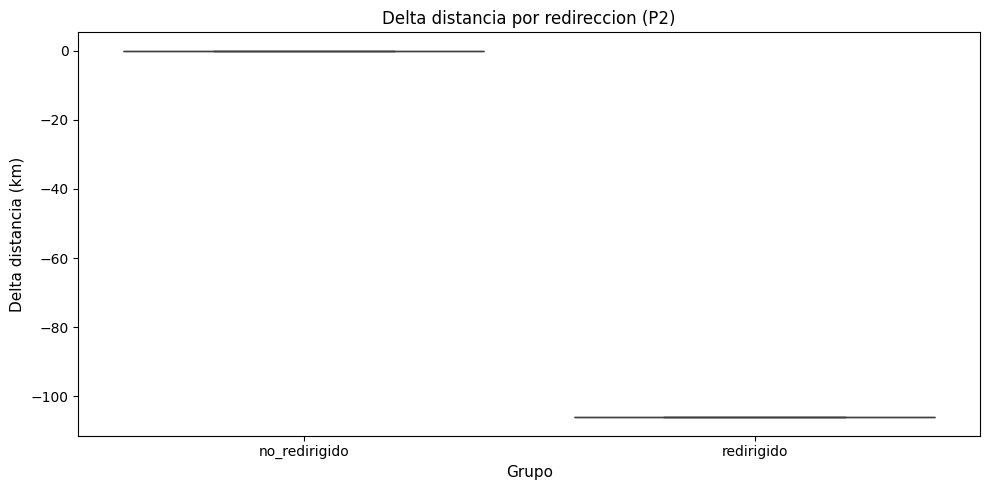

In [320]:
redir_mask = df_vuelos.get('redirigido', pd.Series(False, index=df_vuelos.index)).astype(bool)
if {'distancia_ruta_km','distancia_plan_km'}.issubset(df_vuelos.columns):
    df_vuelos['delta_dist_km'] = df_vuelos['distancia_ruta_km'] - df_vuelos['distancia_plan_km']
else:
    df_vuelos['delta_dist_km'] = np.nan
if 'combustible_consumido_l' in df_vuelos.columns:
    comb_med = df_vuelos.groupby(redir_mask)['combustible_consumido_l'].mean()
    print('Combustible medio redirigido vs no:', comb_med.to_dict())

fig, ax = plt.subplots();
sns.boxplot(data=df_vuelos, x=redir_mask.map({True:'redirigido', False:'no_redirigido'}), y='delta_dist_km', ax=ax)
ax.set_xlabel('Grupo'); ax.set_ylabel('Delta distancia (km)'); ax.set_title('Delta distancia por redireccion (P2)')
plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'box_delta_dist_redir_p2.png'))


### Interior vs exterior: peso en operaciones, retrasos y combustible
Apilado de contribuciones de vuelos interiores y exteriores.


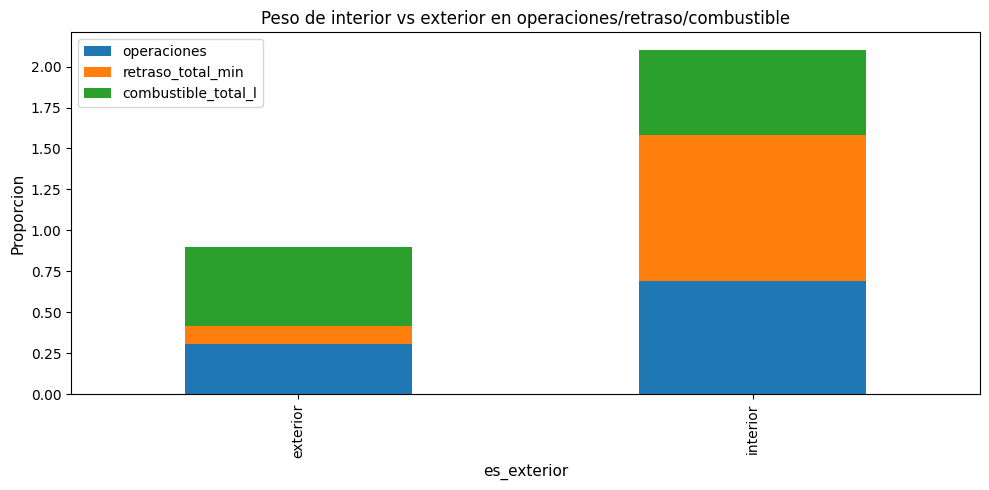

In [321]:
if 'es_exterior' in df_vuelos.columns:
    grupos = df_vuelos['es_exterior'].map({True:'exterior', False:'interior'})
    ops = grupos.value_counts()
    retraso = df_vuelos.groupby(grupos)['retraso_total_min'].sum()
    comb = df_vuelos.groupby(grupos)['combustible_consumido_l'].sum() if 'combustible_consumido_l' in df_vuelos.columns else None
    fig, ax = plt.subplots();
    data = pd.DataFrame({'operaciones': ops, 'retraso_total_min': retraso})
    if comb is not None:
        data['combustible_total_l'] = comb
    data_norm = data.div(data.sum(axis=0), axis=1)
    data_norm.plot(kind='bar', stacked=True, ax=ax)
    ax.set_ylabel('Proporcion'); ax.set_title('Peso de interior vs exterior en operaciones/retraso/combustible')
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'stack_interior_exterior_p2.png'))


### Carga de la red en un dia (eventos)
Ocupacion total y capacidad agregada por minuto (dia 1 representativo).


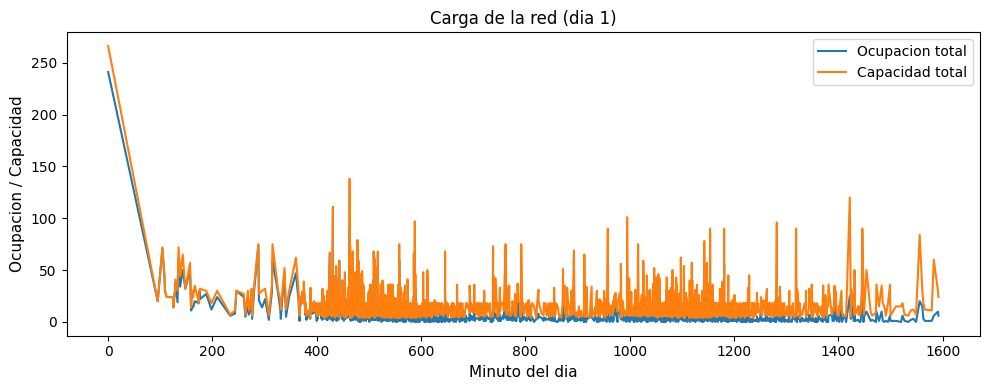

In [322]:
if {'dia','minuto','ocupacion','capacidad'}.issubset(df_eventos.columns):
    dia_ref = df_eventos['dia'].min()
    curva = df_eventos[df_eventos['dia']==dia_ref].groupby('minuto').agg(ocupacion_tot=('ocupacion','sum'), capacidad_tot=('capacidad','sum')).reset_index()
    fig, ax = plt.subplots(figsize=(10,4));
    ax.plot(curva['minuto'], curva['ocupacion_tot'], label='Ocupacion total')
    ax.plot(curva['minuto'], curva['capacidad_tot'], label='Capacidad total')
    ax.set_xlabel('Minuto del dia'); ax.set_ylabel('Ocupacion / Capacidad'); ax.set_title(f'Carga de la red (dia {dia_ref})')
    ax.legend(); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'carga_red_dia1_p2.png'))


### Pareto de aeropuertos por retraso acumulado
Identifica qu? aeropuertos concentran la mayor parte del retraso total (80/20).


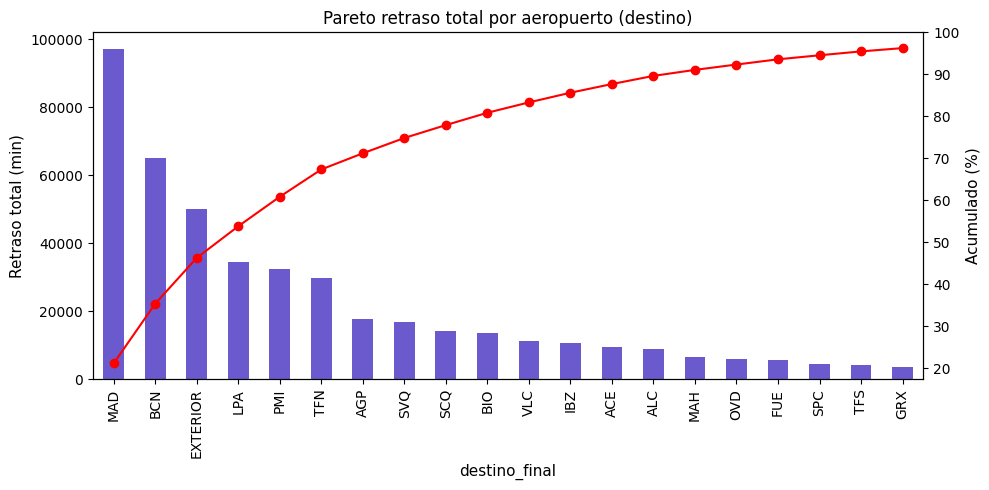

In [323]:
if {'destino_final', 'retraso_total_min'}.issubset(df_vuelos.columns):
    retraso_aer = df_vuelos.groupby('destino_final')['retraso_total_min'].sum().sort_values(ascending=False)
    cum_pct = retraso_aer.cumsum()/retraso_aer.sum()*100
    fig, ax1 = plt.subplots()
    retraso_aer.head(20).plot(kind='bar', ax=ax1, color='slateblue')
    ax2 = ax1.twinx(); ax2.plot(range(len(retraso_aer.head(20))), cum_pct.head(20), color='red', marker='o')
    ax1.set_ylabel('Retraso total (min)'); ax2.set_ylabel('Acumulado (%)')
    ax1.set_title('Pareto retraso total por aeropuerto (destino)')
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'pareto_retraso_aeropuerto_p2.png'))


### Anomalias diarias (z-score)
Detecta dias con retraso total muy por encima/debajo de la media.


Dias anomicos (|z|>2):
dia
4    2.289956
Name: retraso_total_min, dtype: float64


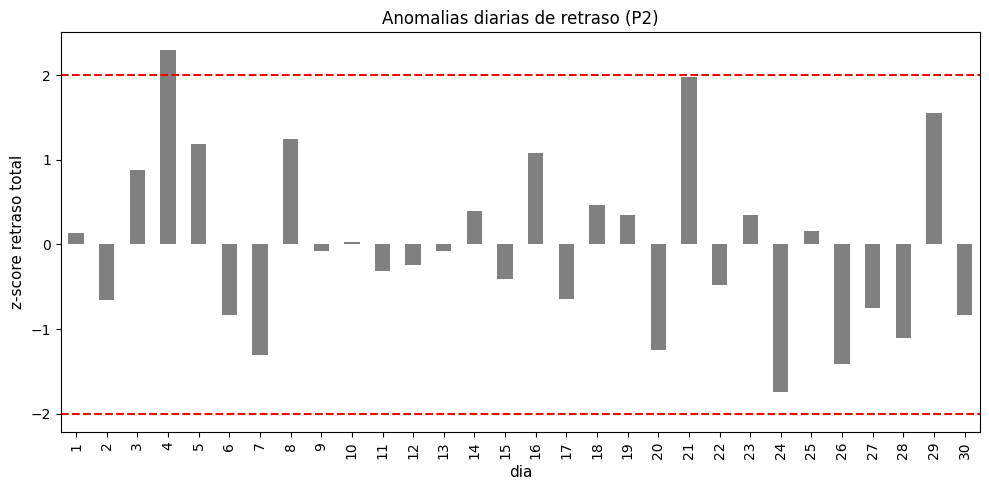

In [324]:
col_delay = 'retraso_total_min'
diario = df_vuelos.groupby('dia')[col_delay].sum()
if len(diario) > 1:
    z = (diario - diario.mean())/diario.std(ddof=0)
    anomalies = z[abs(z) > 2]
    print('Dias anomicos (|z|>2):')
    print(anomalies)
    fig, ax = plt.subplots(); z.plot(kind='bar', ax=ax, color='gray');
    ax.axhline(2, color='red', linestyle='--'); ax.axhline(-2, color='red', linestyle='--')
    ax.set_ylabel('z-score retraso total'); ax.set_title('Anomalias diarias de retraso (P2)')
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'anomalias_retraso_diario_p2.png'))


### Top vuelos por retraso
Ranking de los vuelos con mayor retraso, indicando si fueron redirigidos.


In [325]:
col_delay = 'retraso_total_min'
cols_show = ['id_vuelo','origen','destino_final','redirigido', col_delay]
print(df_vuelos.sort_values(col_delay, ascending=False)[cols_show].head(20))


          id_vuelo origen destino_final  redirigido  retraso_total_min
12533  LPAMAH00275    LPA           MAH       False          81.898695
11183  EASLPA00274    EAS           LPA       False          79.510650
19912  LPABCN00248    LPA           BCN       False          78.920039
6953   LPABCN00251    LPA           BCN       False          76.716045
7992   LPABCN00240    LPA           BCN       False          75.965114
17094  LPAPMI00303    LPA           PMI       False          75.488095
1984   LPABCN00263    LPA           BCN       False          75.437903
19206  PMILPA00298    PMI           LPA       False          74.939456
6958   LPABCN00247    LPA           BCN       False          74.939385
1711   EASLPA00268    EAS           LPA       False          74.079165
10103  LPABCN00273    LPA           BCN       False          74.060919
19153  PMITFN00225    PMI           TFN       False          73.787605
20603  LPABCN00280    LPA           BCN       False          73.641222
12917 

### Ratio de desvio (distancia_real / distancia_plan) y redireccion
Distribucion del desvio de ruta, separando redirigidos y no redirigidos.


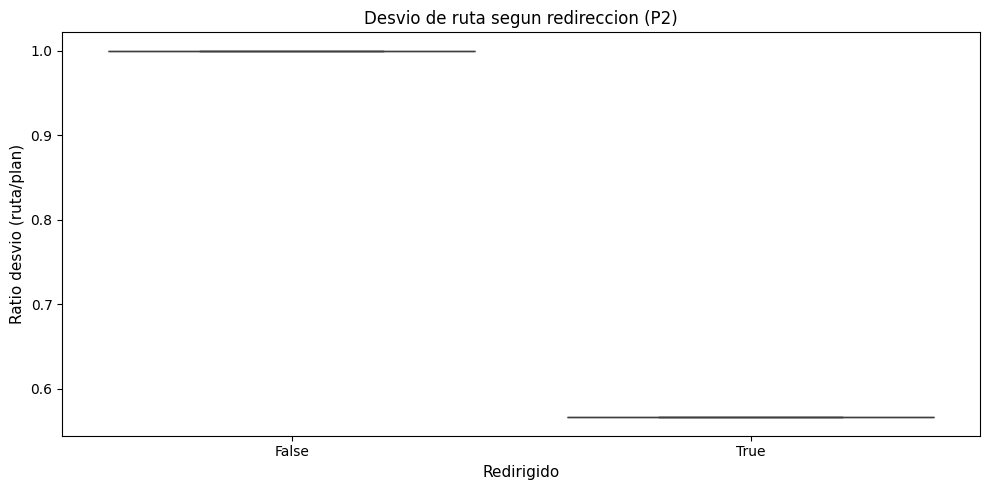

In [326]:
if {'distancia_ruta_km','distancia_plan_km'}.issubset(df_vuelos.columns):
    df_vuelos['ratio_desvio'] = df_vuelos['distancia_ruta_km'] / df_vuelos['distancia_plan_km'].replace(0, np.nan)
    fig, ax = plt.subplots();
    sns.boxplot(data=df_vuelos, x=df_vuelos.get('redirigido', False), y='ratio_desvio', ax=ax)
    ax.set_xlabel('Redirigido'); ax.set_ylabel('Ratio desvio (ruta/plan)'); ax.set_title('Desvio de ruta segun redireccion (P2)')
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'box_ratio_desvio_redir_p2.png'))


### Retraso vs espera en cola
Relacion entre tiempo_espera_cola_min y retraso total.


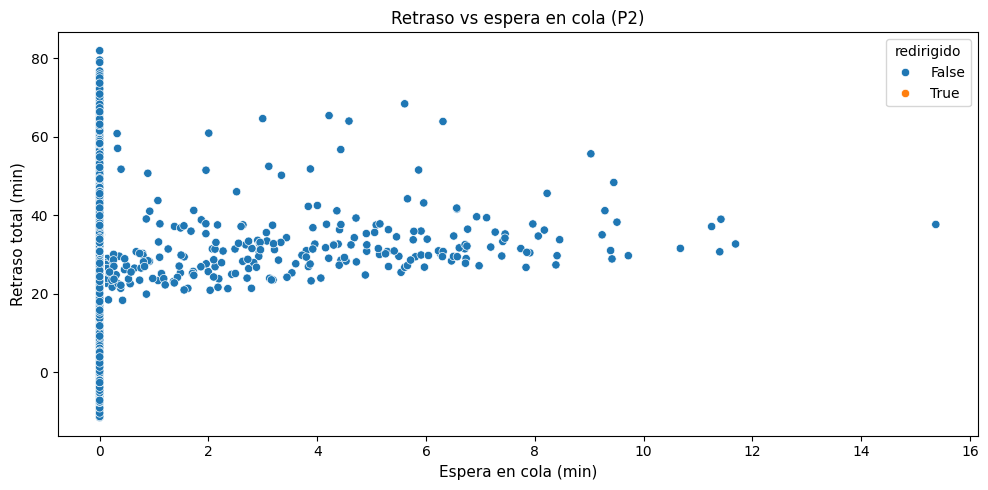

In [327]:
if {'tiempo_espera_cola_min', 'retraso_total_min'}.issubset(df_vuelos.columns):
    fig, ax = plt.subplots();
    sns.scatterplot(data=df_vuelos, x='tiempo_espera_cola_min', y='retraso_total_min', hue=df_vuelos.get('redirigido', None), ax=ax)
    ax.set_xlabel('Espera en cola (min)'); ax.set_ylabel('Retraso total (min)'); ax.set_title('Retraso vs espera en cola (P2)')
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'scatter_retraso_vs_espera_cola_p2.png'))


### Percentiles altos de retraso
p50, p90, p95, p99 globales para retraso_total_min.


In [328]:
col_delay = 'retraso_total_min'
if col_delay in df_vuelos.columns:
    for q in [0.5, 0.9, 0.95, 0.99]:
        print(f"p{int(q*100)}: {df_vuelos[col_delay].quantile(q):.1f} min")


p50: 22.0 min
p90: 37.7 min
p95: 49.2 min
p99: 63.2 min


### Distribucion de numero de vuelos por aeropuerto (origen/destino)
Cuenta de vuelos por aeropuerto de origen y de destino.


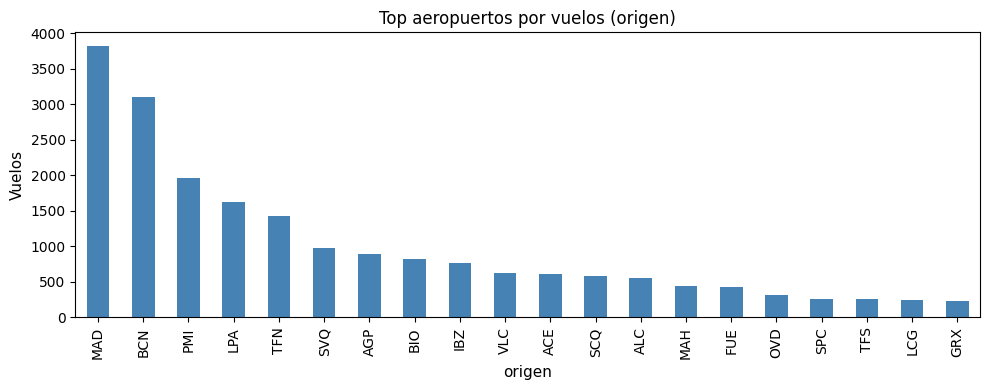

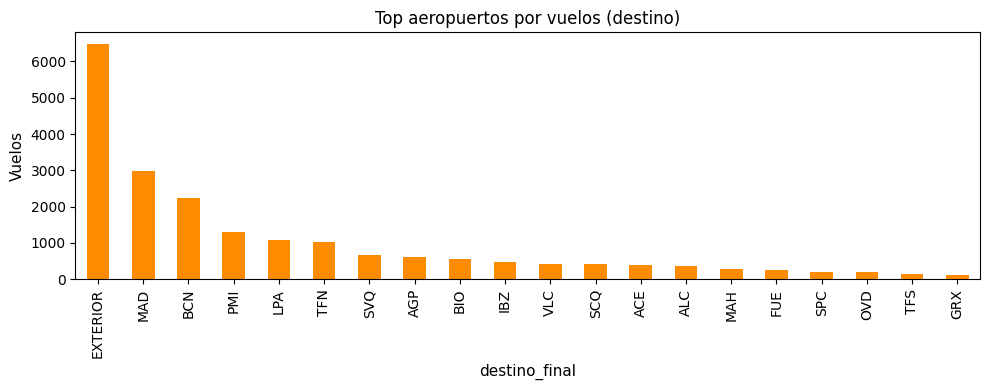

In [329]:
if {'origen','destino_final'}.issubset(df_vuelos.columns):
    vuelos_origen = df_vuelos['origen'].value_counts().sort_values(ascending=False)
    vuelos_dest = df_vuelos['destino_final'].value_counts().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(10,4)); vuelos_origen.head(20).plot(kind='bar', ax=ax, color='steelblue'); ax.set_ylabel('Vuelos'); ax.set_title('Top aeropuertos por vuelos (origen)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'top_vuelos_origen_p2.png'))
    fig, ax = plt.subplots(figsize=(10,4)); vuelos_dest.head(20).plot(kind='bar', ax=ax, color='darkorange'); ax.set_ylabel('Vuelos'); ax.set_title('Top aeropuertos por vuelos (destino)'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'top_vuelos_destino_p2.png'))


### Aeropuertos destino con mayor retraso medio
Ranking por retraso medio en destino.


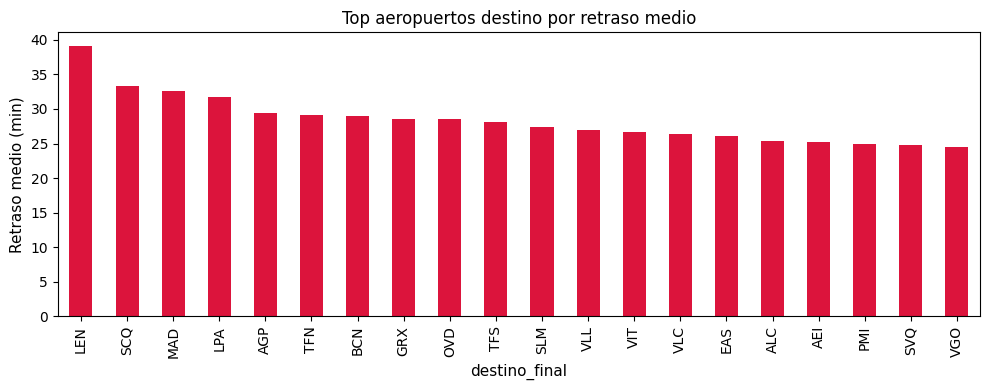

In [330]:
if {'destino_final','retraso_total_min'}.issubset(df_vuelos.columns):
    retraso_dest = df_vuelos.groupby('destino_final')['retraso_total_min'].mean().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(10,4)); retraso_dest.head(20).plot(kind='bar', ax=ax, color='crimson')
    ax.set_ylabel('Retraso medio (min)'); ax.set_title('Top aeropuertos destino por retraso medio'); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'top_destinos_retraso_medio_p2.png'))


### Scatter: retraso medio destino vs capacidad (enriquecidos)
Relacion entre la capacidad del aeropuerto (aeropuertos_enriquecidos.csv) y el retraso medio en destino. Se etiquetan los IDs (MAD, BCN, etc.).


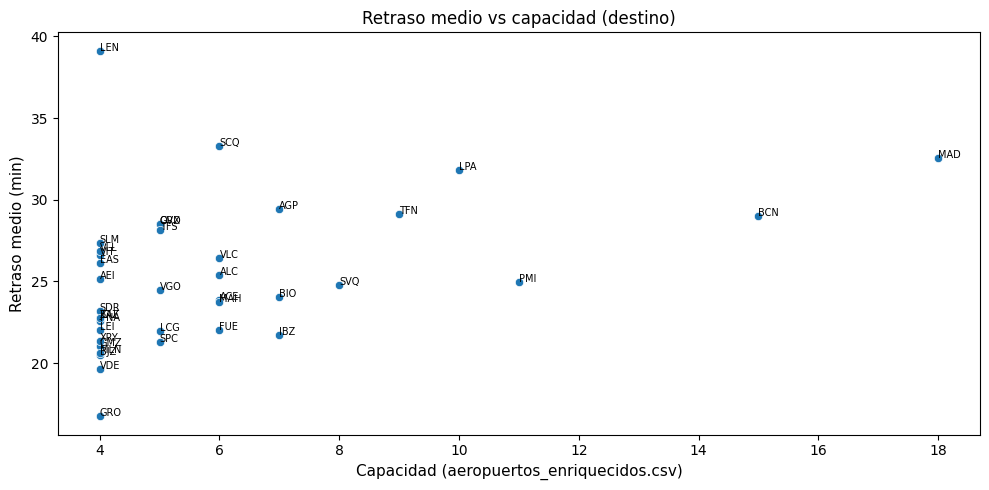

In [331]:
if {'destino_final','retraso_total_min'}.issubset(df_vuelos.columns) and not df_aerop_enr.empty and {'id','capacidad'}.issubset(df_aerop_enr.columns):
    retraso_dest = df_vuelos.groupby('destino_final')['retraso_total_min'].mean()
    cap_series = df_aerop_enr.set_index(df_aerop_enr['id'].astype(str).str.upper())['capacidad']
    retraso_dest_idx = retraso_dest.copy(); retraso_dest_idx.index = retraso_dest_idx.index.str.upper()
    common = retraso_dest_idx.index.intersection(cap_series.index)
    if len(common) > 0:
        comp = pd.DataFrame({'retraso_medio': retraso_dest_idx.loc[common], 'capacidad': cap_series.loc[common]})
        fig, ax = plt.subplots()
        sns.scatterplot(data=comp, x='capacidad', y='retraso_medio', ax=ax)
        for a,row in comp.iterrows():
            ax.text(row['capacidad'], row['retraso_medio'], a, fontsize=7)
        ax.set_xlabel('Capacidad (aeropuertos_enriquecidos.csv)')
        ax.set_ylabel('Retraso medio (min)')
        ax.set_title('Retraso medio vs capacidad (destino)')
        plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, 'scatter_retraso_capacidad_destino_p2.png'))
    else:
        print('Sin interseccion entre destino_final y IDs de aeropuertos_enriquecidos')
else:
    print('No hay columnas necesarias para scatter retraso vs capacidad (revisa df_aerop_enr)')
